<a href="https://colab.research.google.com/github/taceroc/light_echo_modeling/blob/main/LE_diff_z0_same_radii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib


from astropy.coordinates import (cartesian_to_spherical, SkyCoord, Distance, Galactic, EarthLocation, AltAz, CartesianRepresentation, SphericalRepresentation)
from astropy import units as u
# Calculate observer's local sidereal time (LST)
from astropy.time import Time
from astropy.coordinates import EarthLocation

%config InlineBackend.figure_format='retina'

In [2]:
def scatter_phase_function(g = 0, scatter_angle = np.pi / 2):
  mu =  np.cos(scatter_angle)
  return ((1 - g**2) / (1 + g**2  - 2 * g * mu)**(3/2) ) / 4 * np.pi

In [89]:
Deltat = [250] # days
dtoy = 0.00273973 # 1 day = 0.00273973 y
Deltat_y = np.array(Deltat) * dtoy
z0 = [-0.10, 0, 0.3, 1] # pc
pctoly = 3.26156 # 1pc = 3.26156 light-year
z0ly = np.array(z0) * pctoly
# -- point where the plane-parallel slab of dust intersects the line of sight
# -- inclination of the plane, is perpendicular to the line of sight (I am using 89 so the tangent don't die)
alpha = 20 * np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
dt0 = 50 * dtoy
dz0 = 0.02 * pctoly # in ly

c = 1 # in light-year / year
pctom = 3.086e+16
n = 2.3 * (100 ** 3) #m-3
n = n * ( pctom ** 3 ) / ( pctoly ** 3 )
sigma = 5e-22 / (100 ** 2) #m2 #RR paper
sigma = ( sigma / ( (pctom ** 2) ) ) * ( pctoly ** 2 )
albedo = 0.6
Fphi = scatter_phase_function()
print(Fphi, 1/4 * np.pi)
# -- distance source - observer
dkpc = 5 #kpc
d = dkpc * 1000 * pctoly

k = sigma * albedo * Fphi
# L = 15,000 x 3.9e26 # watts = kg m ^2 / s^3
L = (15000 * 3.9e36) * ((60 * 60 * 24 * 365) ** 3) * (pctoly ** 2) / (pctom ** 2)
Ir = k * L * c / (4 * np.pi * (dkpc * 1000 * pctoly)**2)

0.7853981633974483 0.7853981633974483


In [90]:
def xy_plane_ring_noloop(angle, z, ct, dz0, dt0, a, d):
    """
      x and y coordinates in the sky plane of the LE ring. When the dust is a plane.

      Arguments:
        angle: angle in the sky plane where the LE is define
        z: position of the dust plane in ly
        ct: time when the "snap" of the LE is taken from the observer in years
        dz0: thickness of the dust plane in ly
        dt0: duration of the flash light (source) in yeaars
        a: tan(alpha) -  alpha: angle between the normal of the dust plane and the line of sight (z axis)
        d: distance in ly between the source and the obsever

      Returns:
        xs, ys: x and y position in the sky plane in arcseconds

    """

    ti = dt0
    print(ct / c, ti)
    if ct / c <= ti:
      print("r_le_in here")
      r_le_in = 0
    else:
      r_le_in = r_outin(z, ct, dz0, dt0, a, d, "in")
    # -- radii LE ring as seen by z including the thickness of 0.02
    r_le_out = r_outin(z, ct, dz0, dt0, a, d, "out")
    # -- radii LE ring as seen by z including the thickness of 0.02
    # r_le_in = r_outin(z, ct, dz0, dt0, a, "in")
    radii = [r_le_out, r_le_in]
    xs = np.outer(radii, np.cos(angle)) - a * ct
    ys = np.outer(radii, np.sin(angle))
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]

    return xs, ys

def xy_plot_dust_noloop(xs, ys, z):
    xxx = xs.copy()
    yyy = ys.copy()
    xxx[1,:] = xxx[1,::-1]
    yyy[1,:] = yyy[1,::-1]
    new_xs = xxx.copy()
    # new_xs[1,:] = new_xs[1,::-1]
    new_ys = yyy.copy()

    return new_xs, new_ys

In [91]:
def nh_phi_plus_x_dependence(params, x, p = 1, n_h = n):
  """
    Define the density as a pairwise function that depends on the angle phi, the angle in the x,y sky plane
    Arguments
        params: list/array/tuple with the phi angle to be evaluate
        phi_min: min phi where the density value exist
        phi_max: min phi where the density value exist
        n_h: density value
    Return
        Value of the density with same shape as params
  """

  nh = n_h * params * (x ** p)
  nh = np.nan_to_num(nh, nan = 0)
  return nh

def r_outin(z, ct, dz0, dt0, a, d, inout):
    """
      inner and outer radii of the Light Echo given the thickness of the dust plane + the thickness due to the duration of the flash light

      Arguments:
        z: position of the dust plane in ly
        ct: time when the "snap" of the LE is taken from the observer in years
        dz0: thickness of the dust plane in ly
        dt0: duration of the flash light (source) in yeaars
        a: tan(alpha) -  alpha: angle between the normal of the dust plane and the line of sight (z axis)
        d: distance in ly between the source and the obsever
        inout: str that specify if it is the inner or the outer radii must be "out" or "in"

      Returns:
        r_le_in: inner radii or
        r_le_out: outer radii

    """

    if inout == "out":
      size = 1
    else:
      size = -1
    # rho = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) )
    r_le_outin = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) )#+ (size) * 2 * (dz0 / 2) * ct)
    half_obs_thickness = np.sqrt( (ct / r_le_outin) ** 2 * dz0 ** 2 + ( (r_le_outin * c / 2 * ct) + ( c * ct / 2 * r_le_outin )) ** 2 * dt0  ** 2 ) / 2
    # -- include the thickness in xy plane
    r_le_outin = r_le_outin + (size) * half_obs_thickness
    # -- in arcseconds 5kpc = 16308 ly
    # -- degree to arcseconds
    r_le_outin = np.arctan(r_le_outin / d) * (180 / np.pi) * 3600

    return r_le_outin



In [92]:
def surface_brightness_plane_x_noloop(Deltat_yn, z0ly, dz0, func, phi, density_func, p):
  """
    Calculate the surface brightness per dust plane

    Arguments
        Deltat_y: time when the snap of the LE is taken by observer, in year
        z0ly: sitance of the dust in light-years
        dz0: thickness of the plane dust
        Nd: density

      Return:
        the surface brightness array per each dust plane
  """
  surface = np.zeros(len(phi))
  z = np.array(z0ly)
  Deltat_y = np.array(Deltat_yn)
  ct = Deltat_y * c
  # z = z0ly
  # print(surface.shape)
  if z < 0:
    ti = (-2 * z)/(c * (1 + a**2))
    print(ti / dtoy, Deltat_y / dtoy)
    if ct/c >= ti:
      r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) )
      # print(r_le)
      x = r_le * np.cos(phi) - a * ct
      if isinstance(func, (int, float)):
        Nd = np.array([density_func(func * phi, x, p)]).reshape(1, len(phi))
      elif callable(func):
        Nd = np.array([density_func(func(phi), x, p)]).reshape(1, len(phi))
      # -- distance source - dust
      r = z - a * x + ct
      # -- rho = x^2 + y^2 = r_le
      rhodrho  = (dz0 * ct) + (z * c * dt0) + ct * dt0 * (1 + a**2)
      surface = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
    elif ct/c < ti:
      surface = Ir * np.zeros(len(phi))
  elif z >= 0:
    ti = 0
    if ct/c >= 0:
      r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2))
      x = r_le * np.cos(phi) - a * ct
      # print(r_le)
      if isinstance(func, (int, float)):
        Nd = np.array([density_func(func * phi, x, p)]).reshape(1, len(phi))
      elif callable(func):
        Nd = np.array([density_func(func(phi), x, p)]).reshape(1, len(phi))
      # -- distance source - dust
      r = z - a * x + ct
      # -- rho = x^2 + y^2 = r_le
      rhodrho  = (dz0 * ct) + (z * c * dt0) + ct * dt0 * (1 + a**2)
      surface = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)

  return surface


In [93]:
def final_plot_features_noloop(Deltat_yn, z0lyn, density_func, surface_func, phi_min = 0, phi_max = 2 * np.pi, size_phi = 500, func = 1, p = 1):
  """
    Calculate the final x,y coordiantes to plot and surface brightnes for color
    Arguments:
        Deltat_y: list of the time when the snap of the LE is taken by observer, in year
        z0ly: list og the disitance of the dust in light-years
        surface_func: function that define the surface brightness
        density_func: function that define the density of the dust
        phi_min = 0,
        phi_max = 2 * np.pi,
        size_phi = 500
        func: func(angle)
        p: power for the density funct e.g. density ~ func(angle) ** p or x ** p

      Return
        surface array, x and y coordiantes in arcseconds
  """

  z0ly = np.array(z0lyn)
  Deltat_y = np.array(Deltat_yn)
  ct = Deltat_y * c

  phi = np.linspace(phi_min, phi_max, size_phi)
  # print(phi.shape)

  surface = surface_func(Deltat_y, z0ly, dz0, func, phi, density_func, p)
  angle = phi.copy()


  if z0ly < 0:
    # -- time ring star expanding
    ti = (-2 * z0ly)/(c * (1 + a**2))
    # print(ti)
    if ct / c >= ti:
      xs, ys = xy_plane_ring_noloop(angle, z0ly, ct, dz0, dt0, a, d)
      new_xs, new_ys = xy_plot_dust_noloop(xs, ys, z0ly)
    else:
      new_xs = np.zeros((2, len(angle)))
      new_ys = np.zeros((2, len(angle)))
  else:
      xs, ys = xy_plane_ring_noloop(angle, z0ly, ct, dz0, dt0, a, d)
      new_xs, new_ys = xy_plot_dust_noloop(xs, ys, z0ly)



  return surface, new_xs, new_ys

In [160]:
def times_lt_dt0(Deltat_yn, z0lyn, angle, surface_func, density_func, func, p):
  # z0ly = np.array(z0) * pctoly
  # Deltat_y = np.array(Deltat) * dtoy
  z0ly = np.array(z0lyn)
  Deltat_y = np.array(Deltat_yn)
  # time = Deltat_y.copy()
  ct =  Deltat_y * c

  surface_300 = np.zeros((len(z0ly), len(angle)))
  new_xs_300 = np.zeros((len(z0ly), 2, len(angle)))
  new_ys_300 = np.zeros((len(z0ly), 2, len(angle)))

  for ii, qq in enumerate(z0ly):
      if qq < 0:
        surface_300[ii,:], new_xs_300[ii,:,:], new_ys_300[ii,:,:] = final_plot_features_noloop(Deltat_y, qq,  density_func,
                                                                                               surface_func, phi_min = 0, phi_max = 2 * np.pi , size_phi = len(angle),
                                                                                               func = func, p = p)
      else:
        ti = dt0
        # -- for time less than the duration of the flash light, all the dust within the paraboiloid define for the dust and the source would be illuminated.
        if ct / c <= ti:
          # -- rin and rout for the most inner ring keeps the same
          index = [k for k, x in enumerate(z0ly) if x >= 0]
          if ii == index[0]:
            print("inner here")
            print(ii, z0ly[ii] / pctoly)
            surface_300[ii,:], new_xs_300[ii,:,:], new_ys_300[ii,:,:] = final_plot_features_noloop(Deltat_y, qq, density_func,
                                                                                               surface_func, phi_min = 0, phi_max = 2 * np.pi , size_phi = len(angle),
                                                                                               func = func, p = p)
          else:
            print("rest here")
            # -- for the rest of the rings, rin is rout of the previous ring
            r_le_out = r_outin(qq, ct, dz0, dt0, a, d, "out")
            r_le_in = r_outin(z0ly[ii-1], ct, dz0, dt0, a, d, "out")
            print(qq / pctoly, z0ly[ii-1] / pctoly, r_le_out, r_le_in)
            radii = [r_le_out, r_le_in]
            xs = np.outer(radii, np.cos(angle)) - a * ct
            ys = np.outer(radii, np.sin(angle))
            # in order to have a closed area, the circles
            # should be traversed in opposite directions
            xs[1,:] = xs[1,::-1]
            ys[1,:] = ys[1,::-1]
            surface_300[ii,:] = surface_func(Deltat_y, qq, dz0, func, angle, density_func, p)
            new_xs_300[ii,:,:], new_ys_300[ii,:,:] = xy_plot_dust_noloop(xs, ys, qq)

  return surface_300, new_xs_300, new_ys_300


In [95]:
def plot_LE_plane(Deltat_yn, z0lyn, angle, surface_func, density_func, func, p):

  """
    Plot the Light Echo for a (one) given time and multiple dust plane locations

    Arguments:
      Deltat_y: list of time of "screenshot" in years
      z0ly: list of positions of the dust plane in pc from the source in light years
      angle: angle in the sky plane
      surface_func: function that define the surface brightness
      density_func: function that define the density of the dust
      func: func(angle)
      p: power for the density funct e.g. density ~ func(angle) ** p or x ** p

    Return:
      Plot

  """

  z0ly = np.array(z0lyn)
  print(z0ly)
  Deltat_y = np.array(Deltat_yn)
  ct =  Deltat_y * c

  surface_300 = np.zeros((len(z0ly), len(angle)))
  new_xs_300 = np.zeros((len(z0ly), 2, len(angle)))
  new_ys_300 = np.zeros((len(z0ly), 2, len(angle)))


  if ct / c >= dt0:
    for ii, qq in enumerate(z0ly):
      surface_300[ii,:], new_xs_300[ii,:,:], new_ys_300[ii,:,:] = final_plot_features_noloop(Deltat_y, qq,  density_func,
                                                                                    surface_func, phi_min = 0, phi_max = 2 * np.pi , size_phi = len(angle),
                                                                                    func = func, p = p)

  else:
    print("plot LE here")
    surface_300, new_xs_300, new_ys_300 = times_lt_dt0(Deltat_y, z0ly, angle, surface_func, density_func, func = func, p = p)


  surface_300_norm = ( surface_300.copy() - np.nanmin(surface_300.copy())  ) / (np.nanmax(surface_300.copy()) - np.nanmin(surface_300.copy()))

  xs = new_xs_300.copy()
  ys = new_ys_300.copy()


  fig, ax = plt.subplots(1, 1, figsize=(12, 8))


  ax.set_title("time = %s days"%int(Deltat_y / dtoy))
  cmap = matplotlib.colormaps.get_cmap('Greys')
  normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))
  limit_max = np.max([max(np.ravel(xs)), max(np.ravel(ys))])
  limit_min = np.min([min(np.ravel(xs)), min(np.ravel(ys))])

  ax.set_xlim(limit_min - 10, limit_max + 10)
  ax.set_ylim(limit_min - 10, limit_max + 10)


  legend_dust = []

  for i, z in enumerate(z0ly):
    if z < 0:
      # -- time ring star expanding
      ti = (-2 * z)/(c * (1 + a**2))
      # print(ti)
      if ct / c >= ti:
        print(Deltat_y / dtoy, ti / dtoy)
        print(z / pctoly)
        legend_dust.append(z / pctoly)
        for k in range(len(angle)):
          ax.plot(xs[i, :, k], ys[i, :, k], marker = "None", color=cmap(normalize(surface_300_norm[i, k])))#, label="%s"%(z/pctoly))
      else:
        ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
    else:
      for k in range(len(angle)):
        ax.plot(xs[i, :, k], ys[i, :, k], marker = "None", color=cmap(normalize(surface_300_norm[i, k])))#, label="%s"%(z/pctoly))
        legend_dust.append(z / pctoly)
      ax.scatter(-a * ct, 0, marker="*", s=7, color="orange")

  ax.legend(set(legend_dust), loc='best',  ncol=4)

  cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

  ax.set_xlabel("arcsec")
  ax.set_ylabel("arcsec")
  ax.set_box_aspect(1)

  cb = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
  cb.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

  def label_cbrt(x,pos):
      return "{:.1f}".format(x)

  cb.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
  # cb.update_ticks()
  # # plt.tight_layout()
  # # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
  # # print(set(legend_dust))
  plt.show()


  return ax, surface_300, xs, ys

In [96]:
Deltat_y / dtoy

array([250.])

In [97]:
asss = np.array([2])

In [98]:
asss.shape

(1,)

In [99]:
z0ly

array([-0.326156,  0.      ,  0.978468,  3.26156 ])

In [100]:
size_phi = 300

In [101]:
angle = np.linspace(0, 2 * np.pi, size_phi)


[-0.326156  0.        0.978468  3.26156 ]
210.24188200658946 [250.]
[0.6849325] 0.1369865
[0.6849325] 0.1369865
[0.6849325] 0.1369865
[0.6849325] 0.1369865
[250.] 210.24188200658946
-0.1


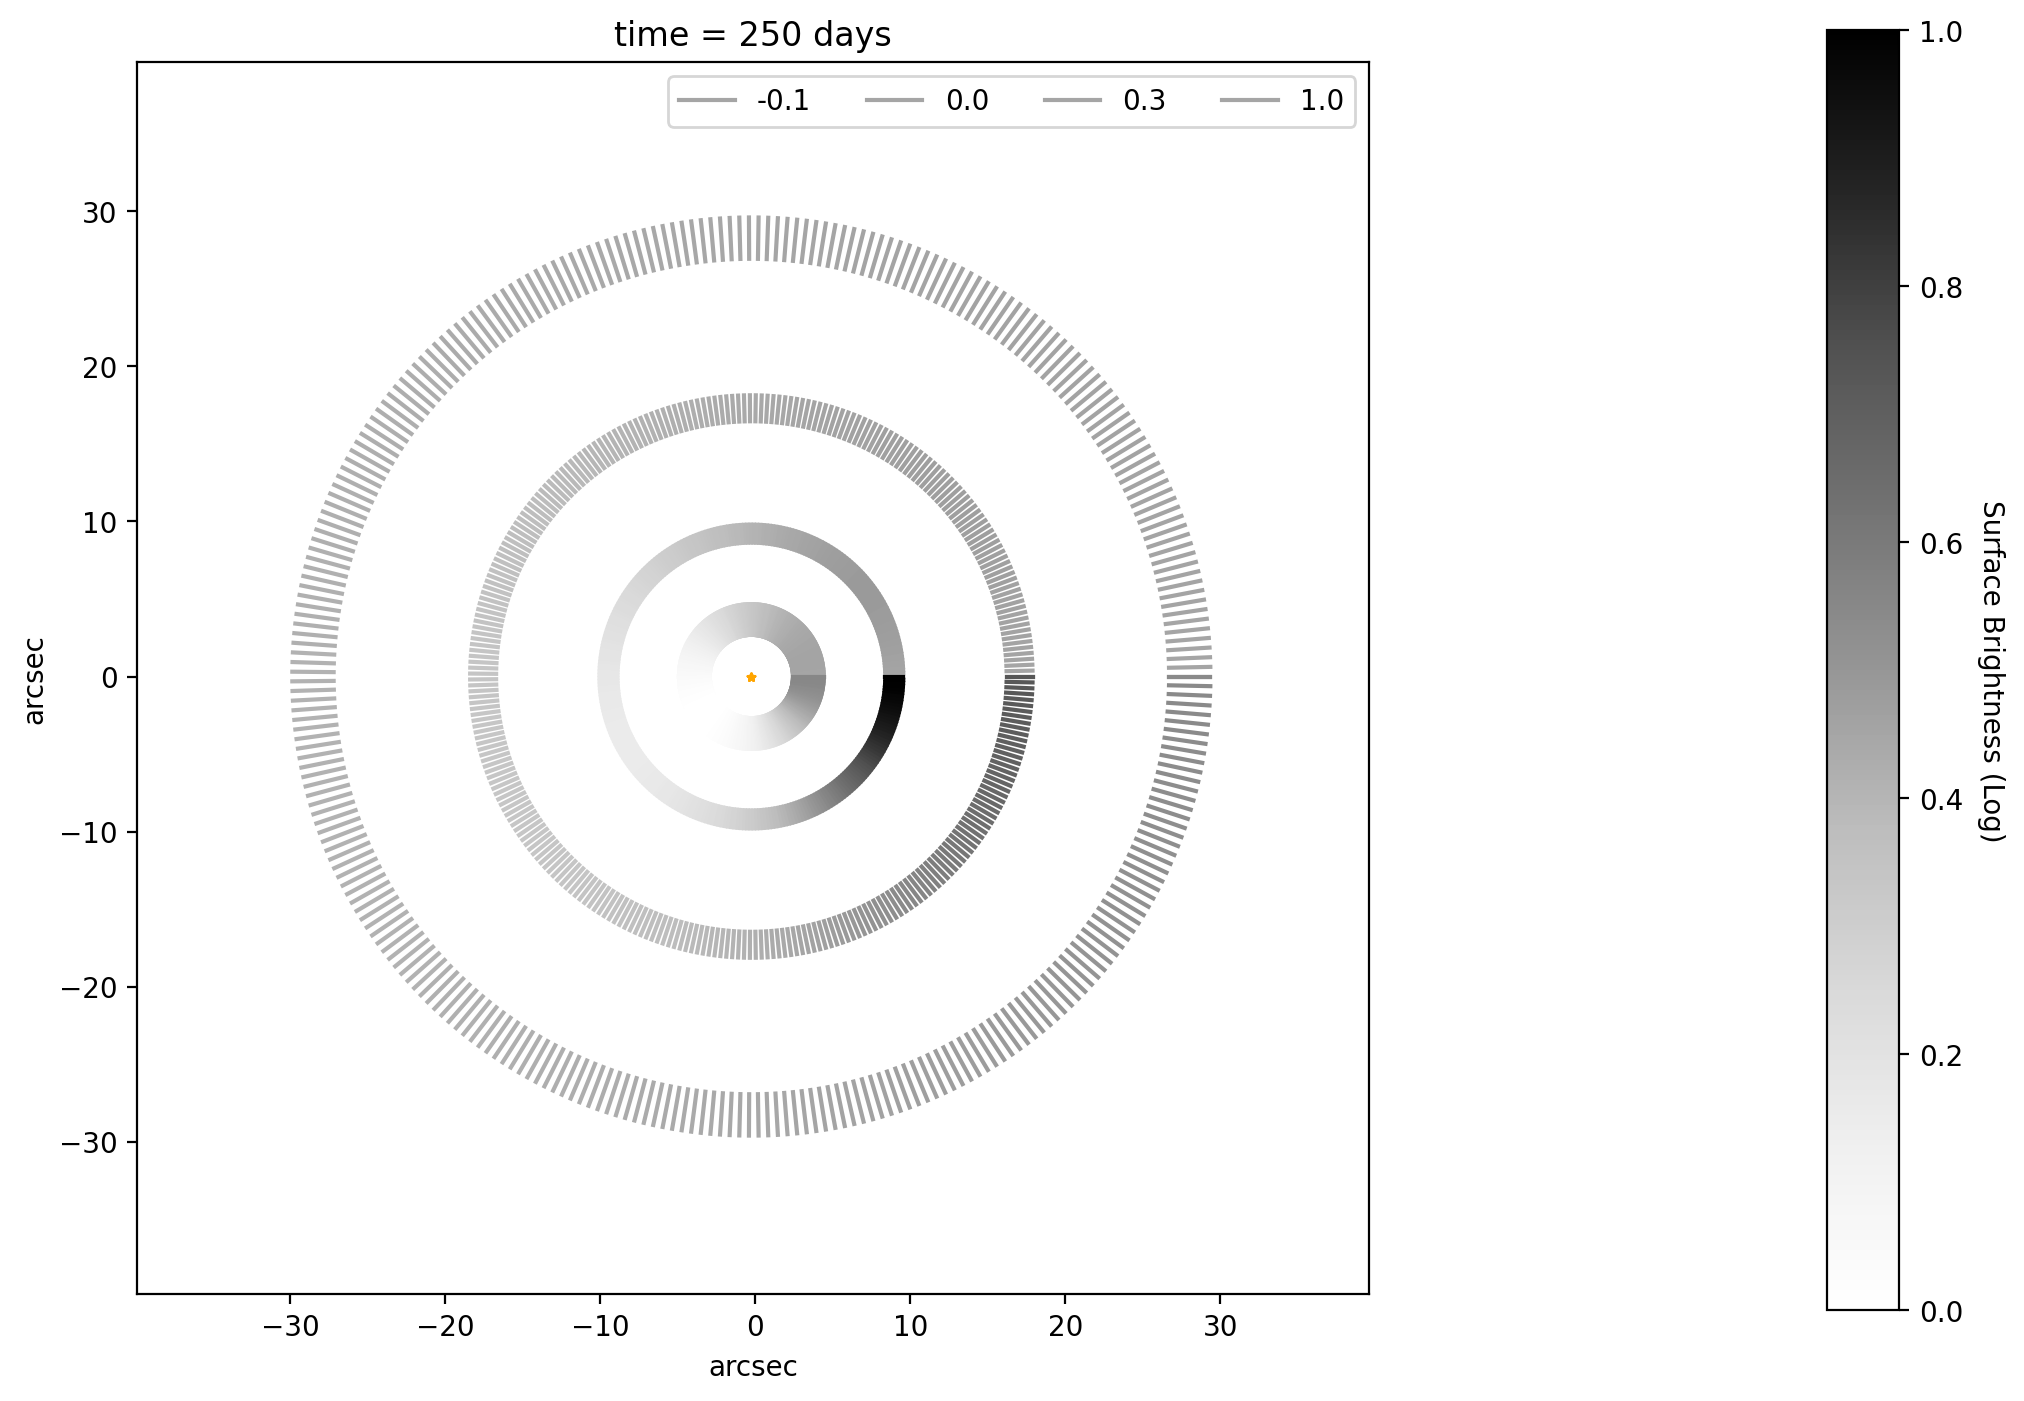

In [102]:
ax, surface_300, xs, ys = plot_LE_plane(Deltat_y, z0ly, angle, surface_func = surface_brightness_plane_x_noloop, density_func = nh_phi_plus_x_dependence, func = 1, p = 1)

[-0.326156  0.        0.978468  3.26156 ]
plot LE here
210.24188200658946 49.0
inner here
1 0.0
0.13424677000000002 0.1369865
r_le_in here
rest here
0.3 0.0 6.851111532903685 2.194963798380565
rest here
1.0 0.3 12.097927523855196 6.851111532903685


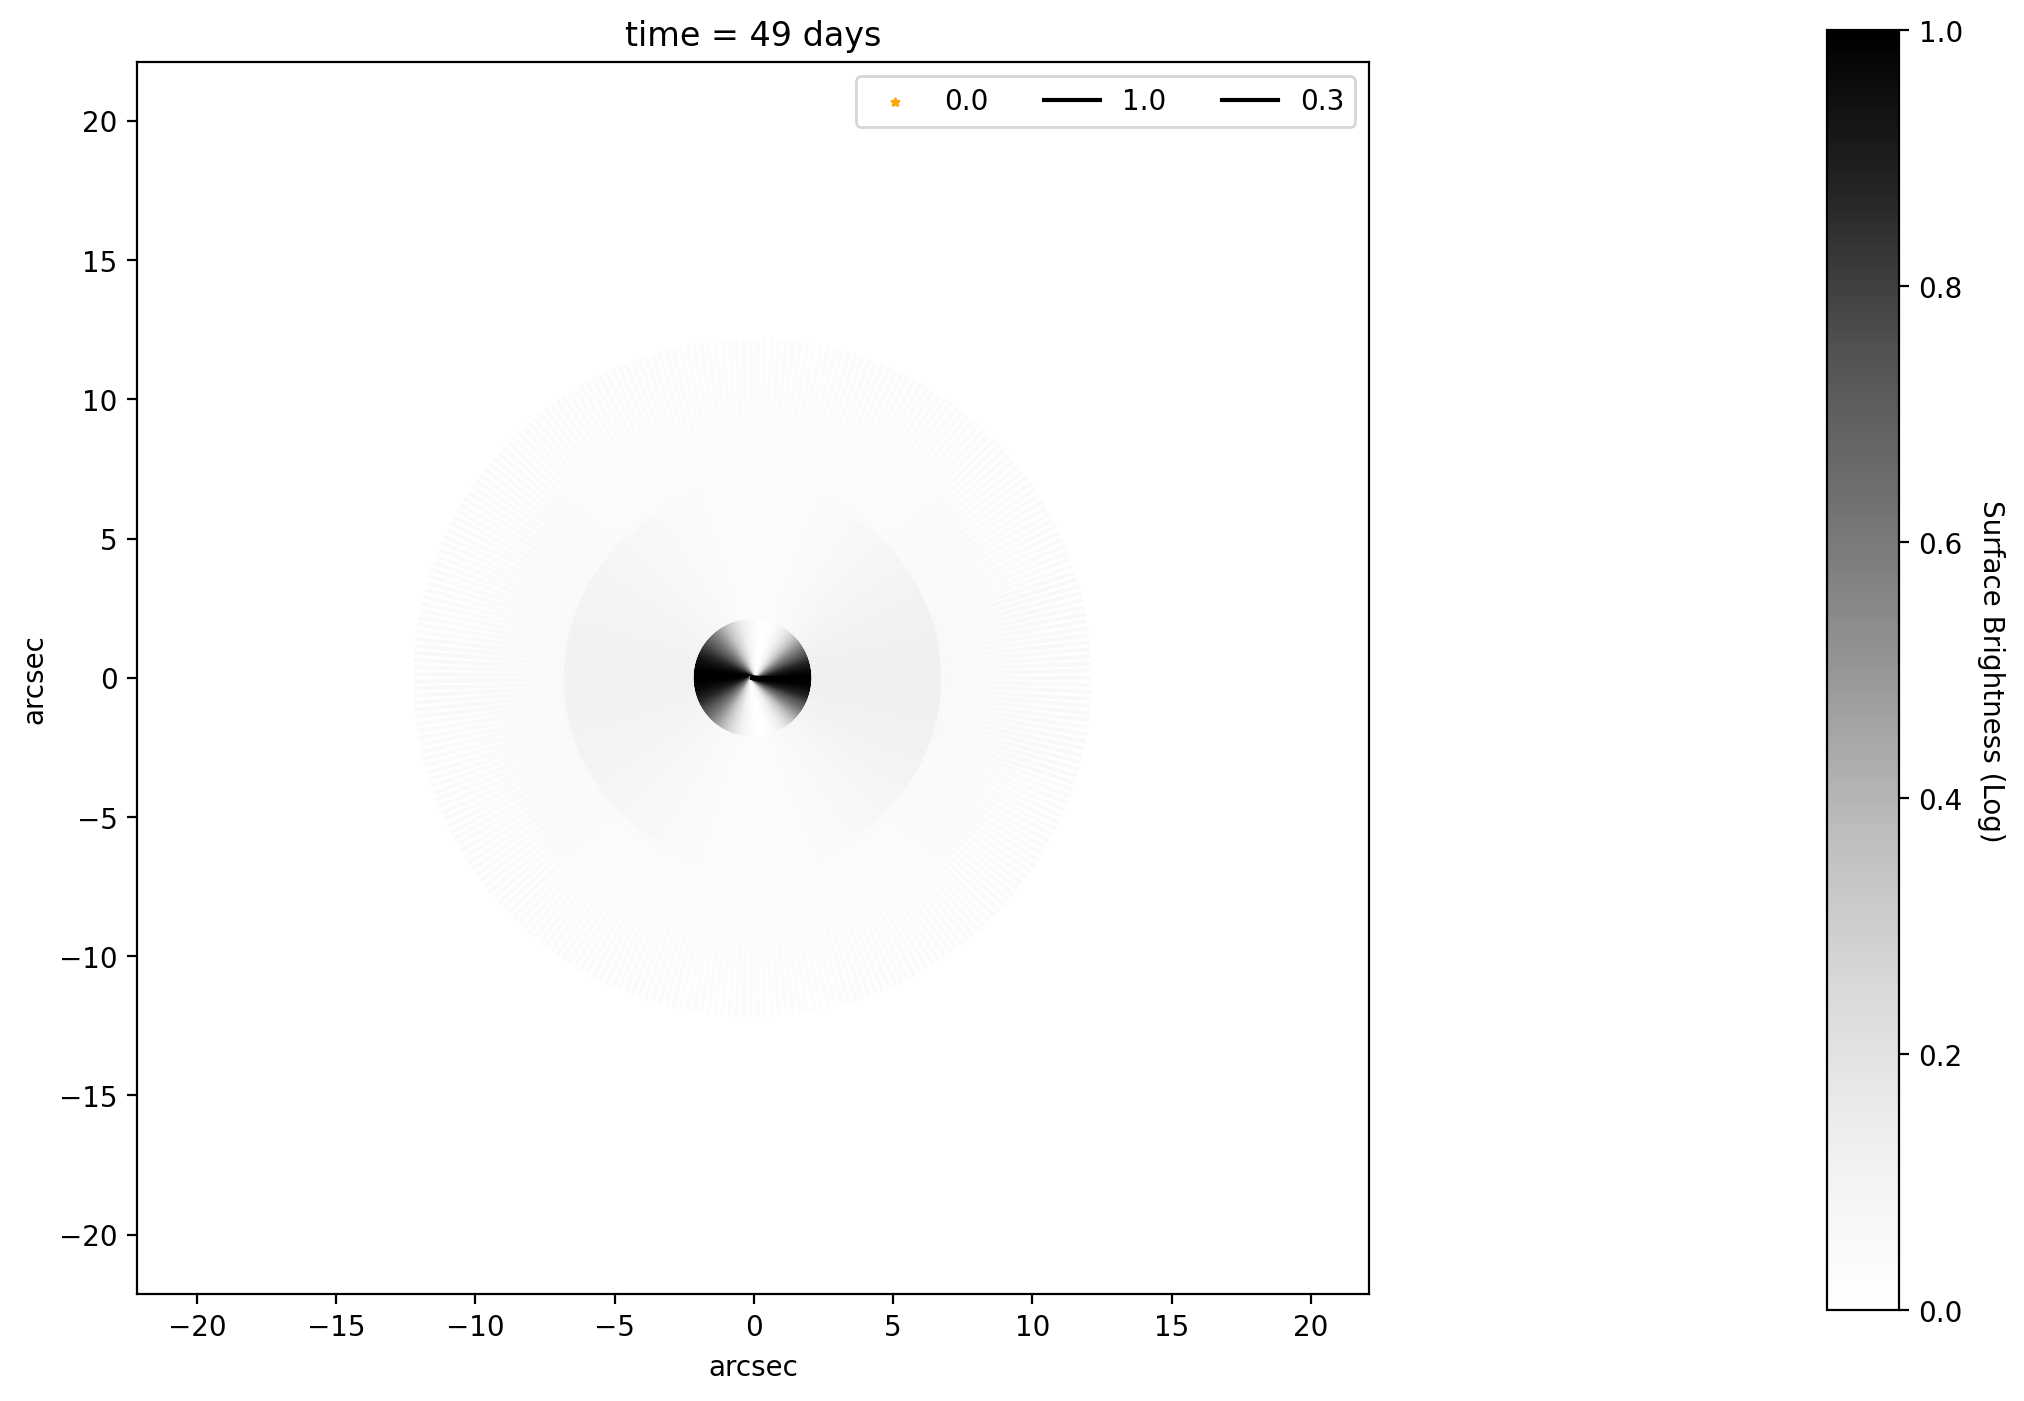

In [103]:
ax, surface_300, xs, ys = plot_LE_plane(49 * dtoy, z0ly, angle, surface_func = surface_brightness_plane_x_noloop, density_func = nh_phi_plus_x_dependence, func = np.cos, p = 1)

In [104]:
def nh_xonly_dependence(params, p = 1, n_h = n):
  """
    Define the density as a pairwise function that depends on the angle phi, the angle in the x,y sky plane
    Arguments
        params: list/array/tuple with the x to be evaluate
        phi_min: min phi where the density value exist
        phi_max: min phi where the density value exist
        n_h: density value
    Return
        Value of the density with same shape as params
  """

  nh = n_h * (params ** p)
  nh = np.nan_to_num(nh, nan = 0)
  return nh

In [105]:
def surface_brightness_plane_xonly(Deltat_yn, z0lyn, dz0, func, phi, density_func, p):
  """
    Calculate the surface brightness per dust plane

    Arguments
        Deltat_y: time when the snap of the LE is taken by observer, in year
        z0ly: sitance of the dust in light-years
        dz0: thickness of the plane dust
        Nd: density

      Return:
        the surface brightness array per each dust plane
  """
  surface = np.zeros(len(phi))
  z = np.array(z0lyn)
  print(z, z.shape)
  Deltat_y = np.array(Deltat_yn)
  ct = Deltat_y * c
  # print(surface.shape)
  if z < 0:
    ti = (-2 * z)/(c * (1 + a**2))
    print(ti / dtoy, Deltat_y / dtoy)
    if ct/c >= ti:
      r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) )
      # print(r_le)
      x = r_le * np.cos(phi) - a * ct
      if isinstance(func, (int, float)):
        Nd = np.array([density_func(x, p)]).reshape(1, len(phi))
      elif callable(func):
        Nd = np.array([density_func(func(x), p)]).reshape(1, len(phi))
      # -- distance source - dust
      r = z - a * x + ct
      # -- rho = x^2 + y^2 = r_le
      rhodrho  = (dz0 * ct) + (z * c * dt0) + ct * dt0 * (1 + a**2)
      surface = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
    elif ct/c < ti:
      surface = Ir * np.zeros(len(phi))
  elif z >= 0:
    ti = 0
    if ct/c >= 0:
      r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2))
      x = r_le * np.cos(phi) - a * ct
      print(r_le)
      # print(r_le)
      if isinstance(func, (int, float)):
        Nd = np.array([density_func(x, p)]).reshape(1, len(phi))
      elif callable(func):
        Nd = np.array([density_func(func(x), p)]).reshape(1, len(phi))
      # -- distance source - dust
      r = z - a * x + ct
      # -- rho = x^2 + y^2 = r_le
      rhodrho  = (dz0 * ct) + (z * c * dt0) + ct * dt0 * (1 + a**2)
      surface = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)

  return surface


[-0.326156  0.        0.978468  3.26156 ]
-0.326156 ()
210.24188200658946 80.0
0.0 ()
0.23324478148683445
0.2191784 0.1369865
0.9784679999999999 ()
0.6952130820642266
0.2191784 0.1369865
3.26156 ()
1.2182487975363823
0.2191784 0.1369865


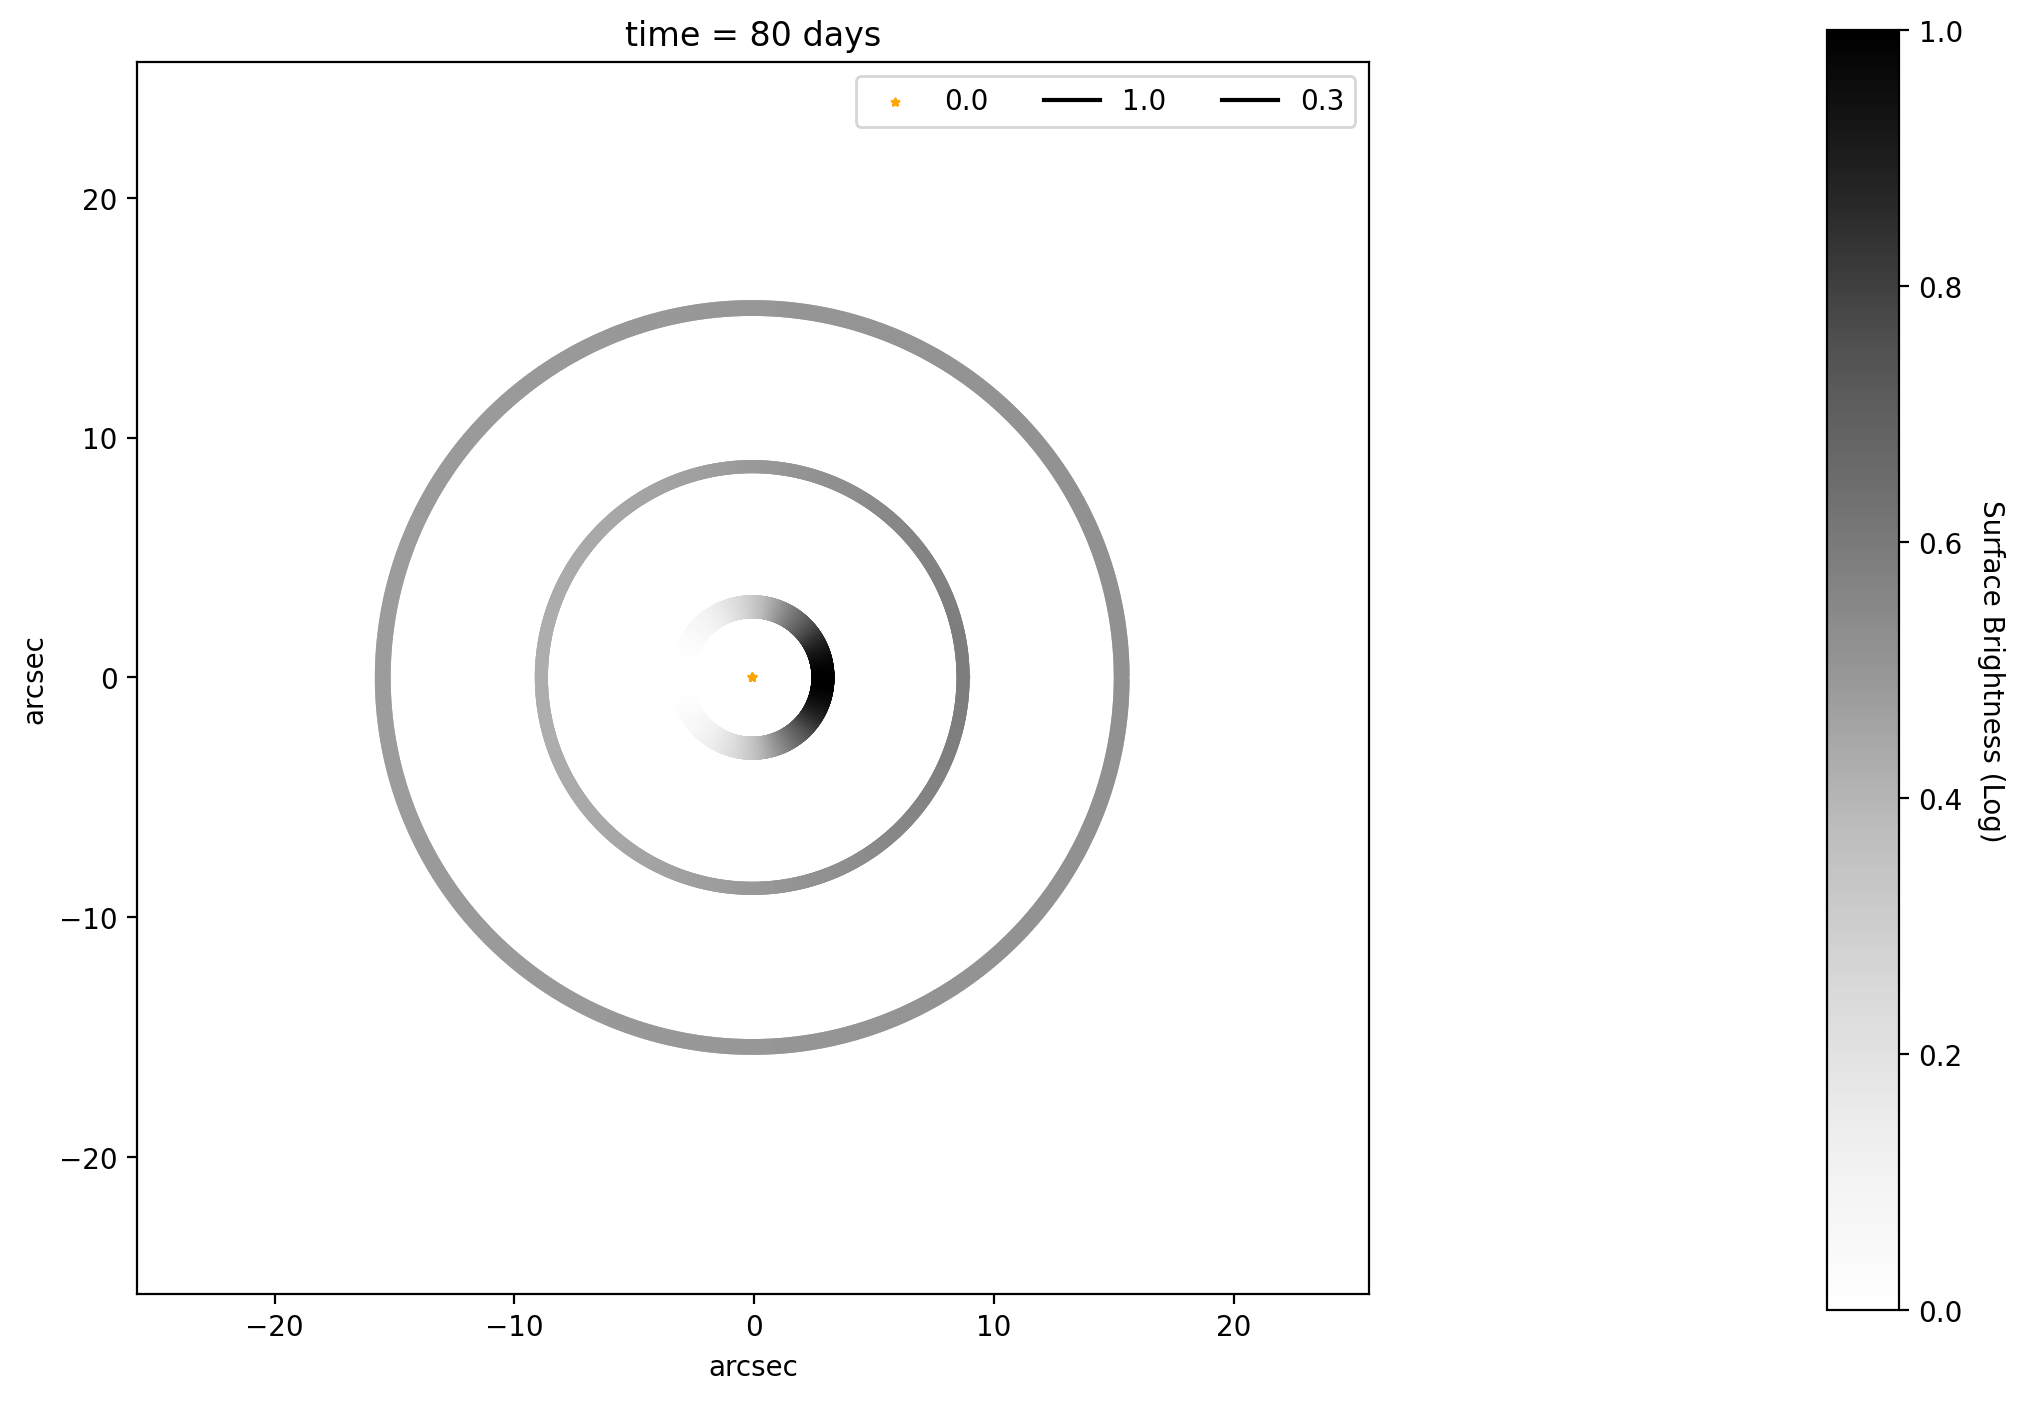

In [106]:
angle = np.linspace(0, 2 * np.pi, 1000)
ax, surface_300, xs, ys = plot_LE_plane(80 * dtoy, z0ly, angle, surface_func = surface_brightness_plane_xonly, density_func = nh_xonly_dependence, func = 1, p = 1)


In [107]:
import sympy as sym

Calculate the 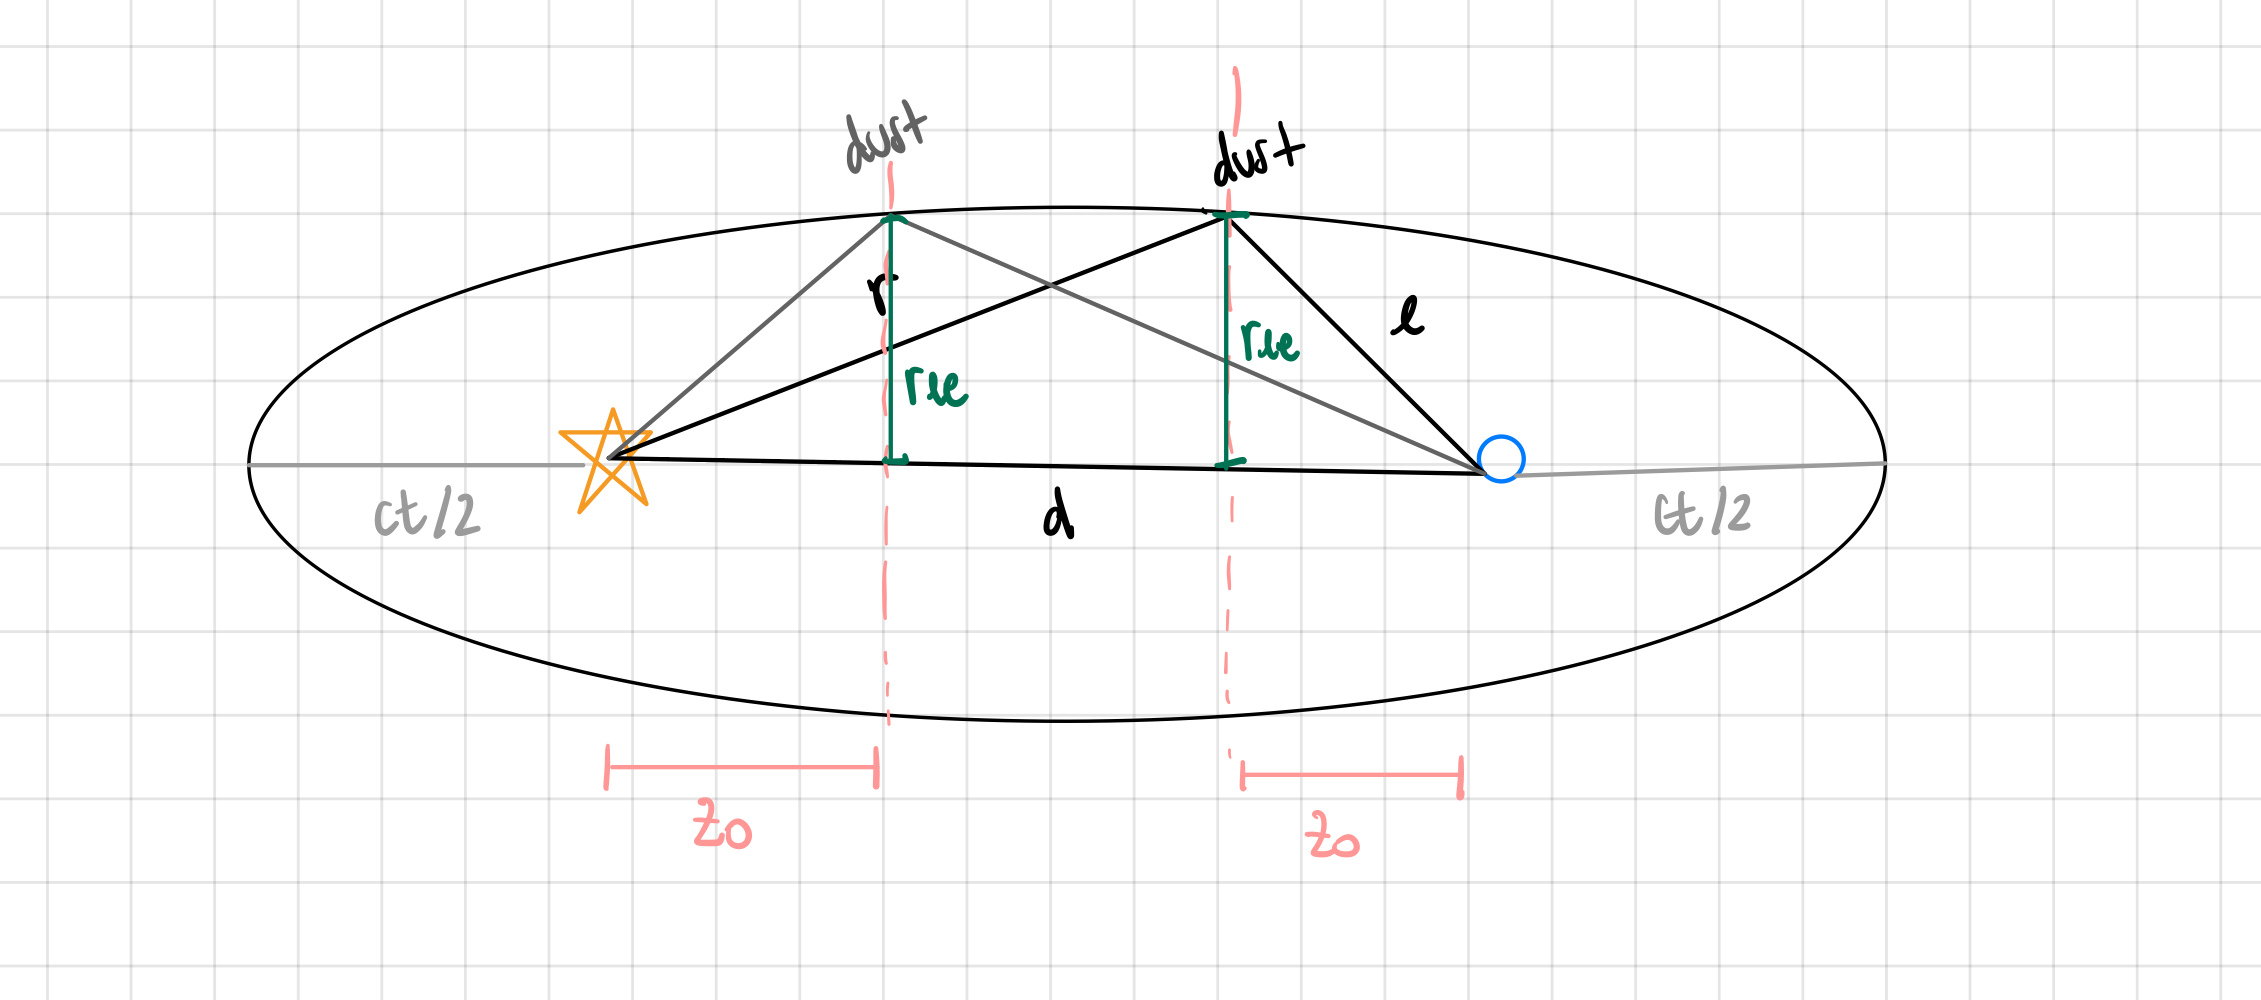

Plot the LE produce by the grey dust and the black dust. They should have the same radii because they intersect the ellipse at the same distance from the line of sight.

Grey dust is at a distancce z$_0$ from the source

Black dust is at a distance d - z$_0$ from the source

$r_{le}^2 = 2z_0 ct + (ct)^2 (1+a^2)$

$2z_0 ct_1 + (ct_1)^2 (1+a^2)^2 = 2(d-z_0) ct_2 + (ct_2)^2 (1+a^2)$

Assuming that the angle of the normal is the same for both planes***


$t_1 = x$

$t_2 = y$

$f = \frac{2z_0}{(1+a^2)}$

$g = \frac{2d}{(1+a^2)}$

$y^2 + (g-f)y - fx - x^2 = 0$


In [108]:
x = sym.Symbol('x')
y = sym.Symbol('y')
f = sym.Symbol('f')
g = sym.Symbol('g')


In [109]:
sym.solveset(y**2 + (g-f)*y - f*x  - x**2, y)

{f/2 - g/2 - sqrt(f**2 - 2*f*g + 4*f*x + g**2 + 4*x**2)/2, f/2 - g/2 + sqrt(f**2 - 2*f*g + 4*f*x + g**2 + 4*x**2)/2}

In [110]:
z0

[-0.1, 0, 0.3, 1]

In [111]:
d / pctoly

5000.0

Do for $t_1 = 280$ days, $z_0 = 100 pc$

In [112]:
t1 = 500 * dtoy
z0 = 1000 * pctoly

[3261.56]
3261.56 ()
94.5405674882008
1.369865 0.1369865


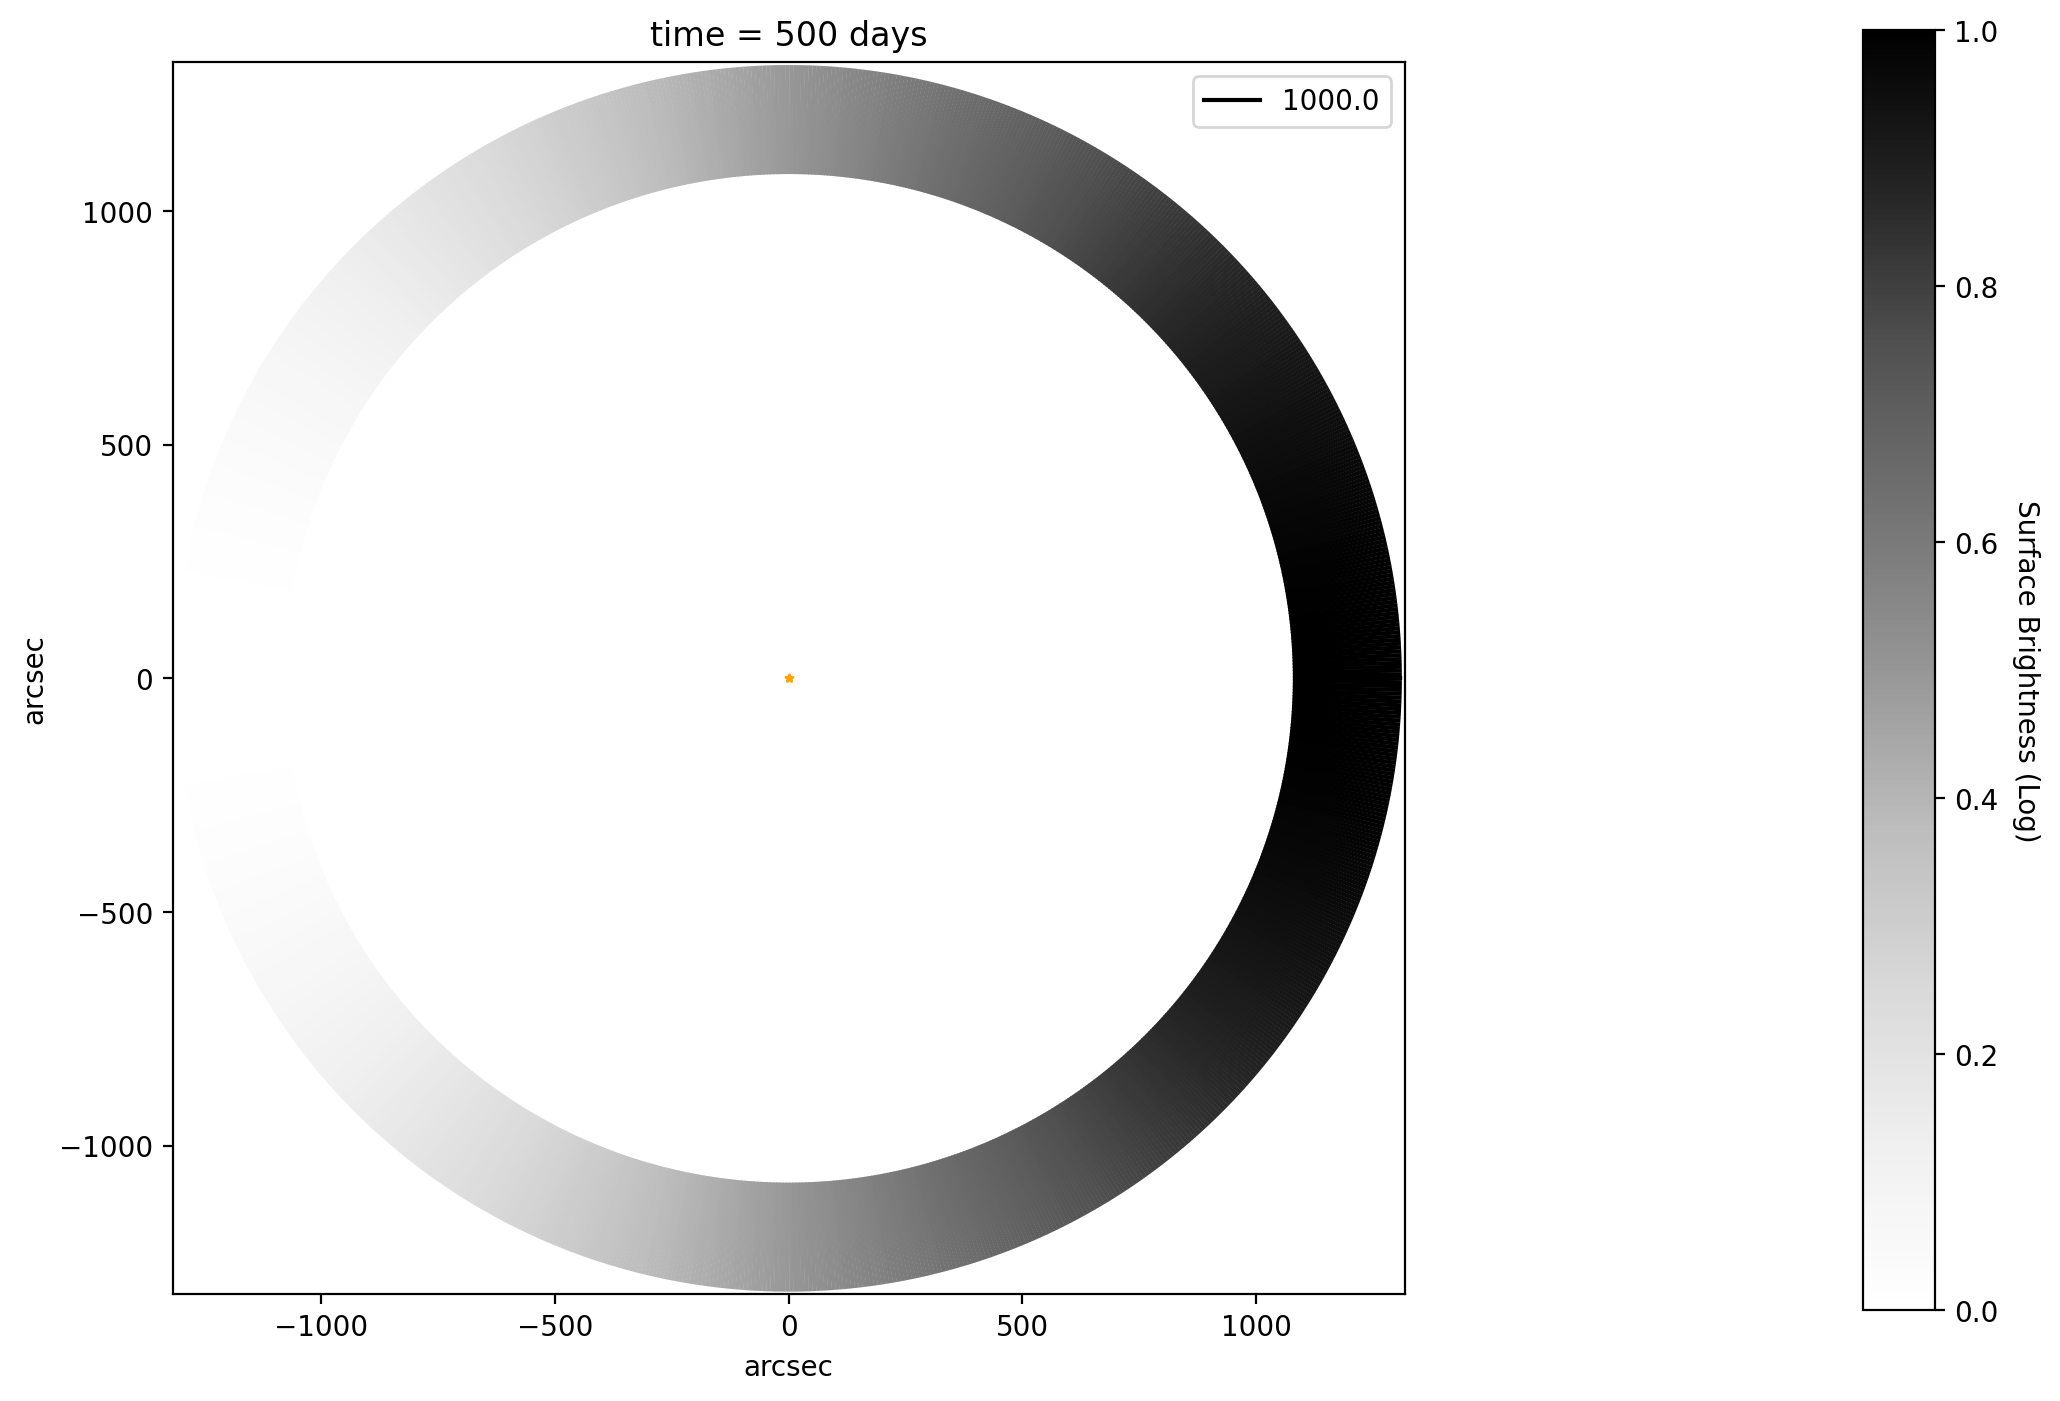

In [113]:
angle = np.linspace(0, 2 * np.pi, 1000)
ax1, surface_3001, new_xs_3001, new_ys_3001 = plot_LE_plane(t1, np.array([z0]), angle, surface_func = surface_brightness_plane_xonly, density_func = nh_xonly_dependence, func = 1, p = 1)

In [114]:
surface_3001.mean()

1062205022.8472188

In [115]:
dt0

0.1369865

0.34254260314082785
[13046.24]
13046.24 ()
94.54056748808024
0.34254260314082785 0.1369865


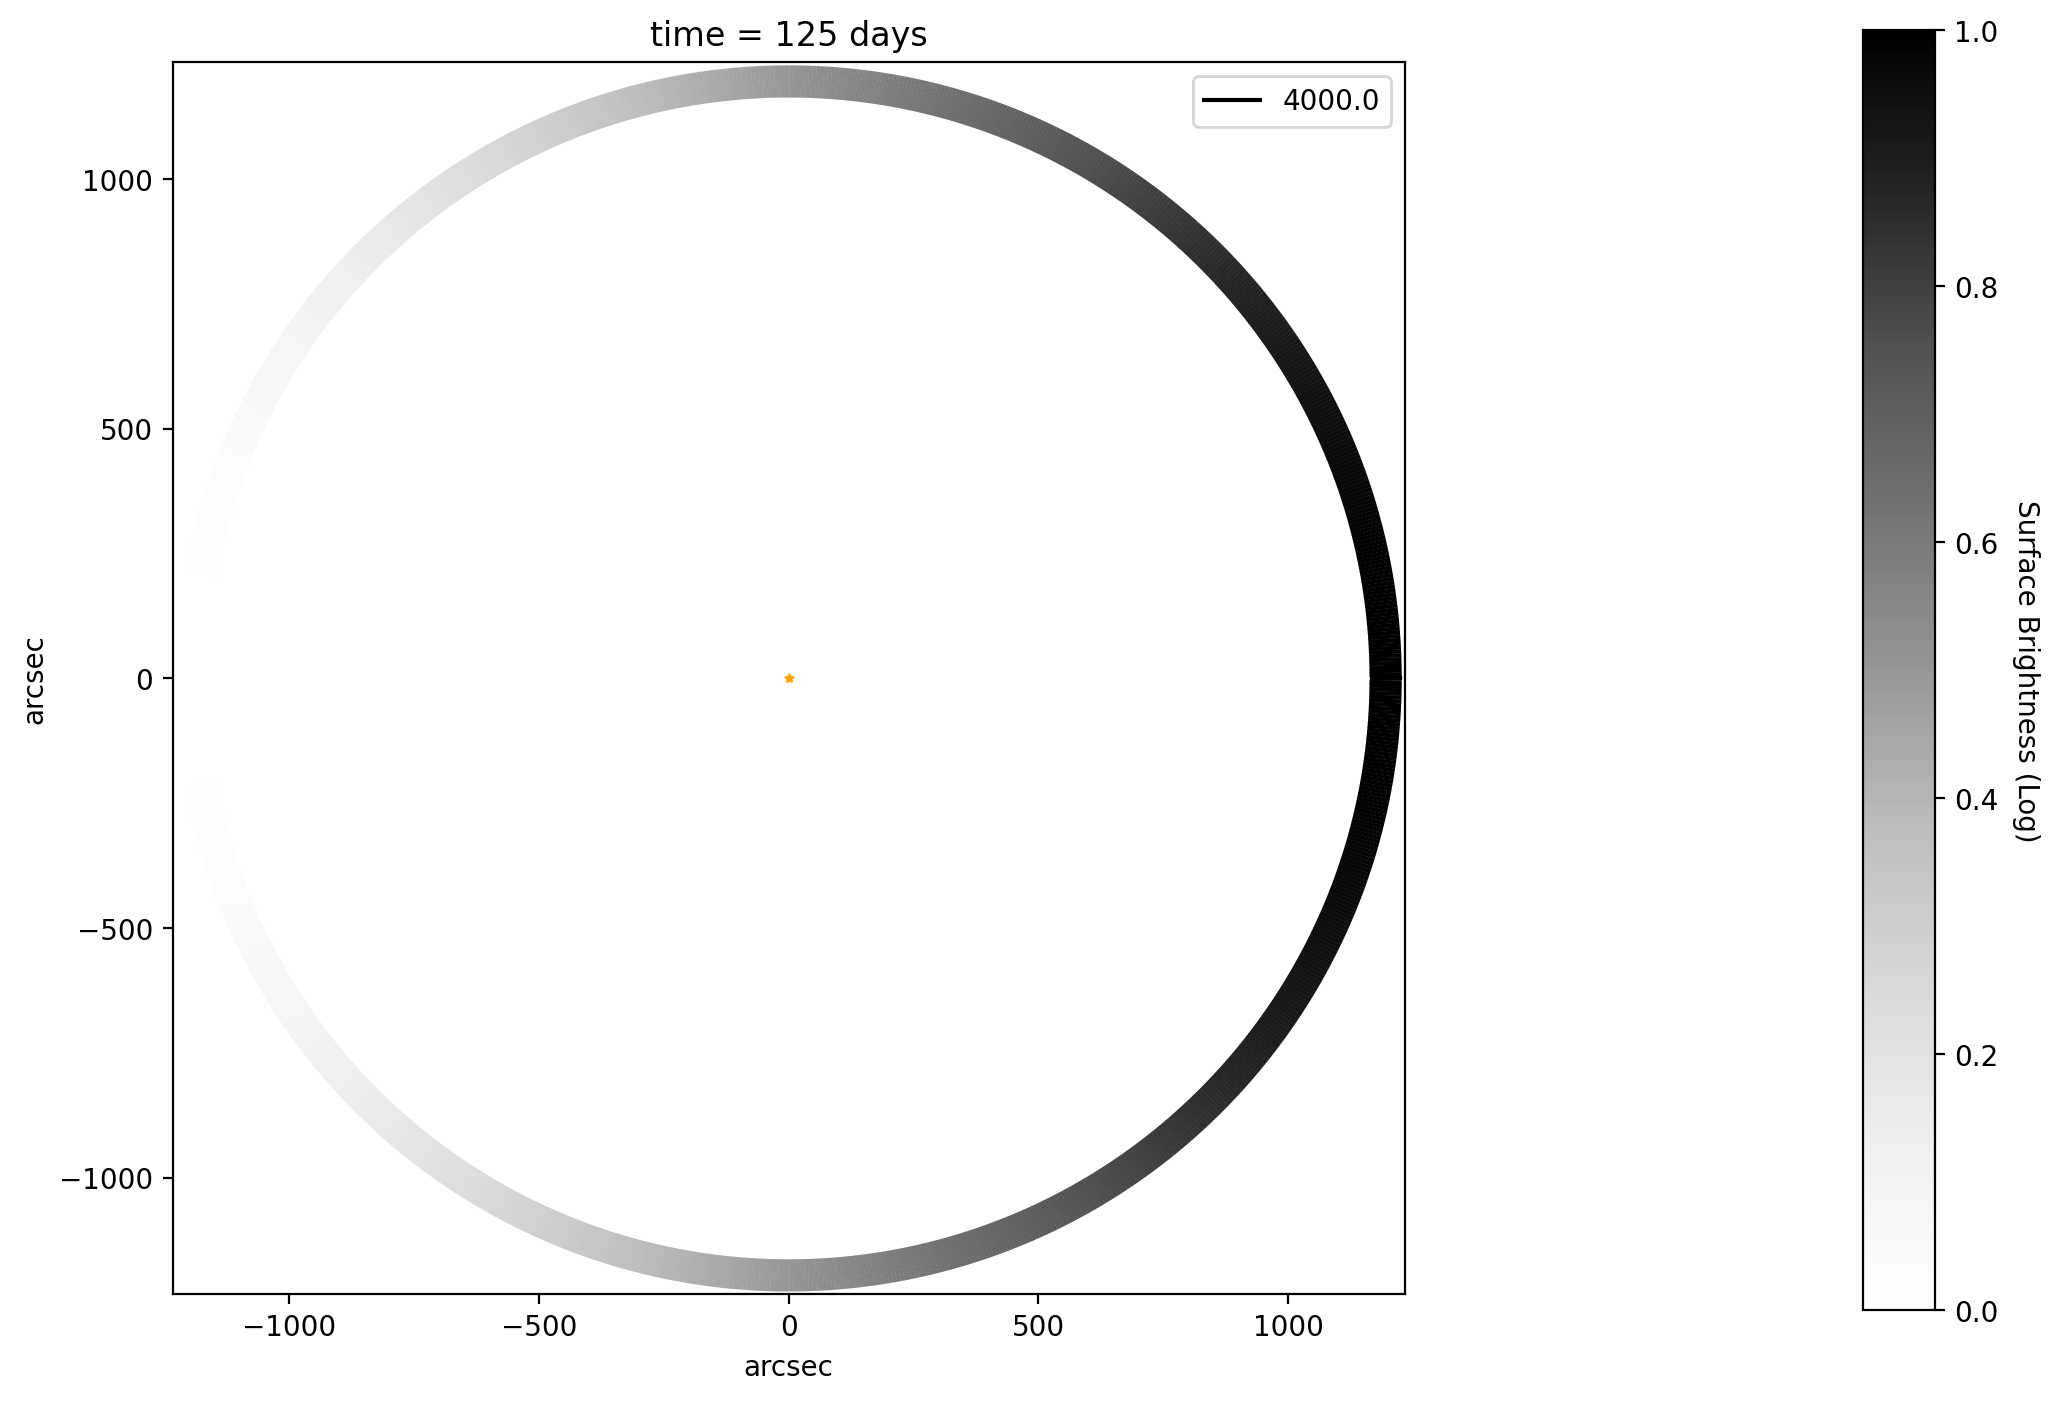

In [117]:
angle = np.linspace(0, 2 * np.pi, 1000)
f = 2 * (z0) / (1 + a**2)
g = (2 * d) / (1 + a**2)
t2yp = f/2 - g/2 + np.sqrt(f**2 - 2*f*g + 4*f*t1 + g**2 + 4*t1**2) / 2
print(t2yp)
ax2, surface_3002, new_xs_3002, new_ys_3002 = plot_LE_plane(t2yp, np.array([d - z0]), angle, surface_func = surface_brightness_plane_xonly, density_func = nh_xonly_dependence, func = 1, p = 1)

In [118]:
np.mean(surface_3002)

66266463.01197461

In [119]:
surface_300 = np.vstack((surface_3001, surface_3002))
surface_300_norm = ( surface_300.copy() - np.nanmin(surface_300.copy())  ) / (np.nanmax(surface_300.copy()) - np.nanmin(surface_300.copy()))


In [120]:
surface_300.shape

(2, 1000)

In [121]:
np.mean(surface_300, axis=1)

array([1.06220502e+09, 6.62664630e+07])

In [122]:
xs = np.vstack((new_xs_3001, new_xs_3002))
ys = np.vstack((new_ys_3001, new_ys_3002))
ct = t1 * dtoy
xs.shape

(2, 2, 1000)

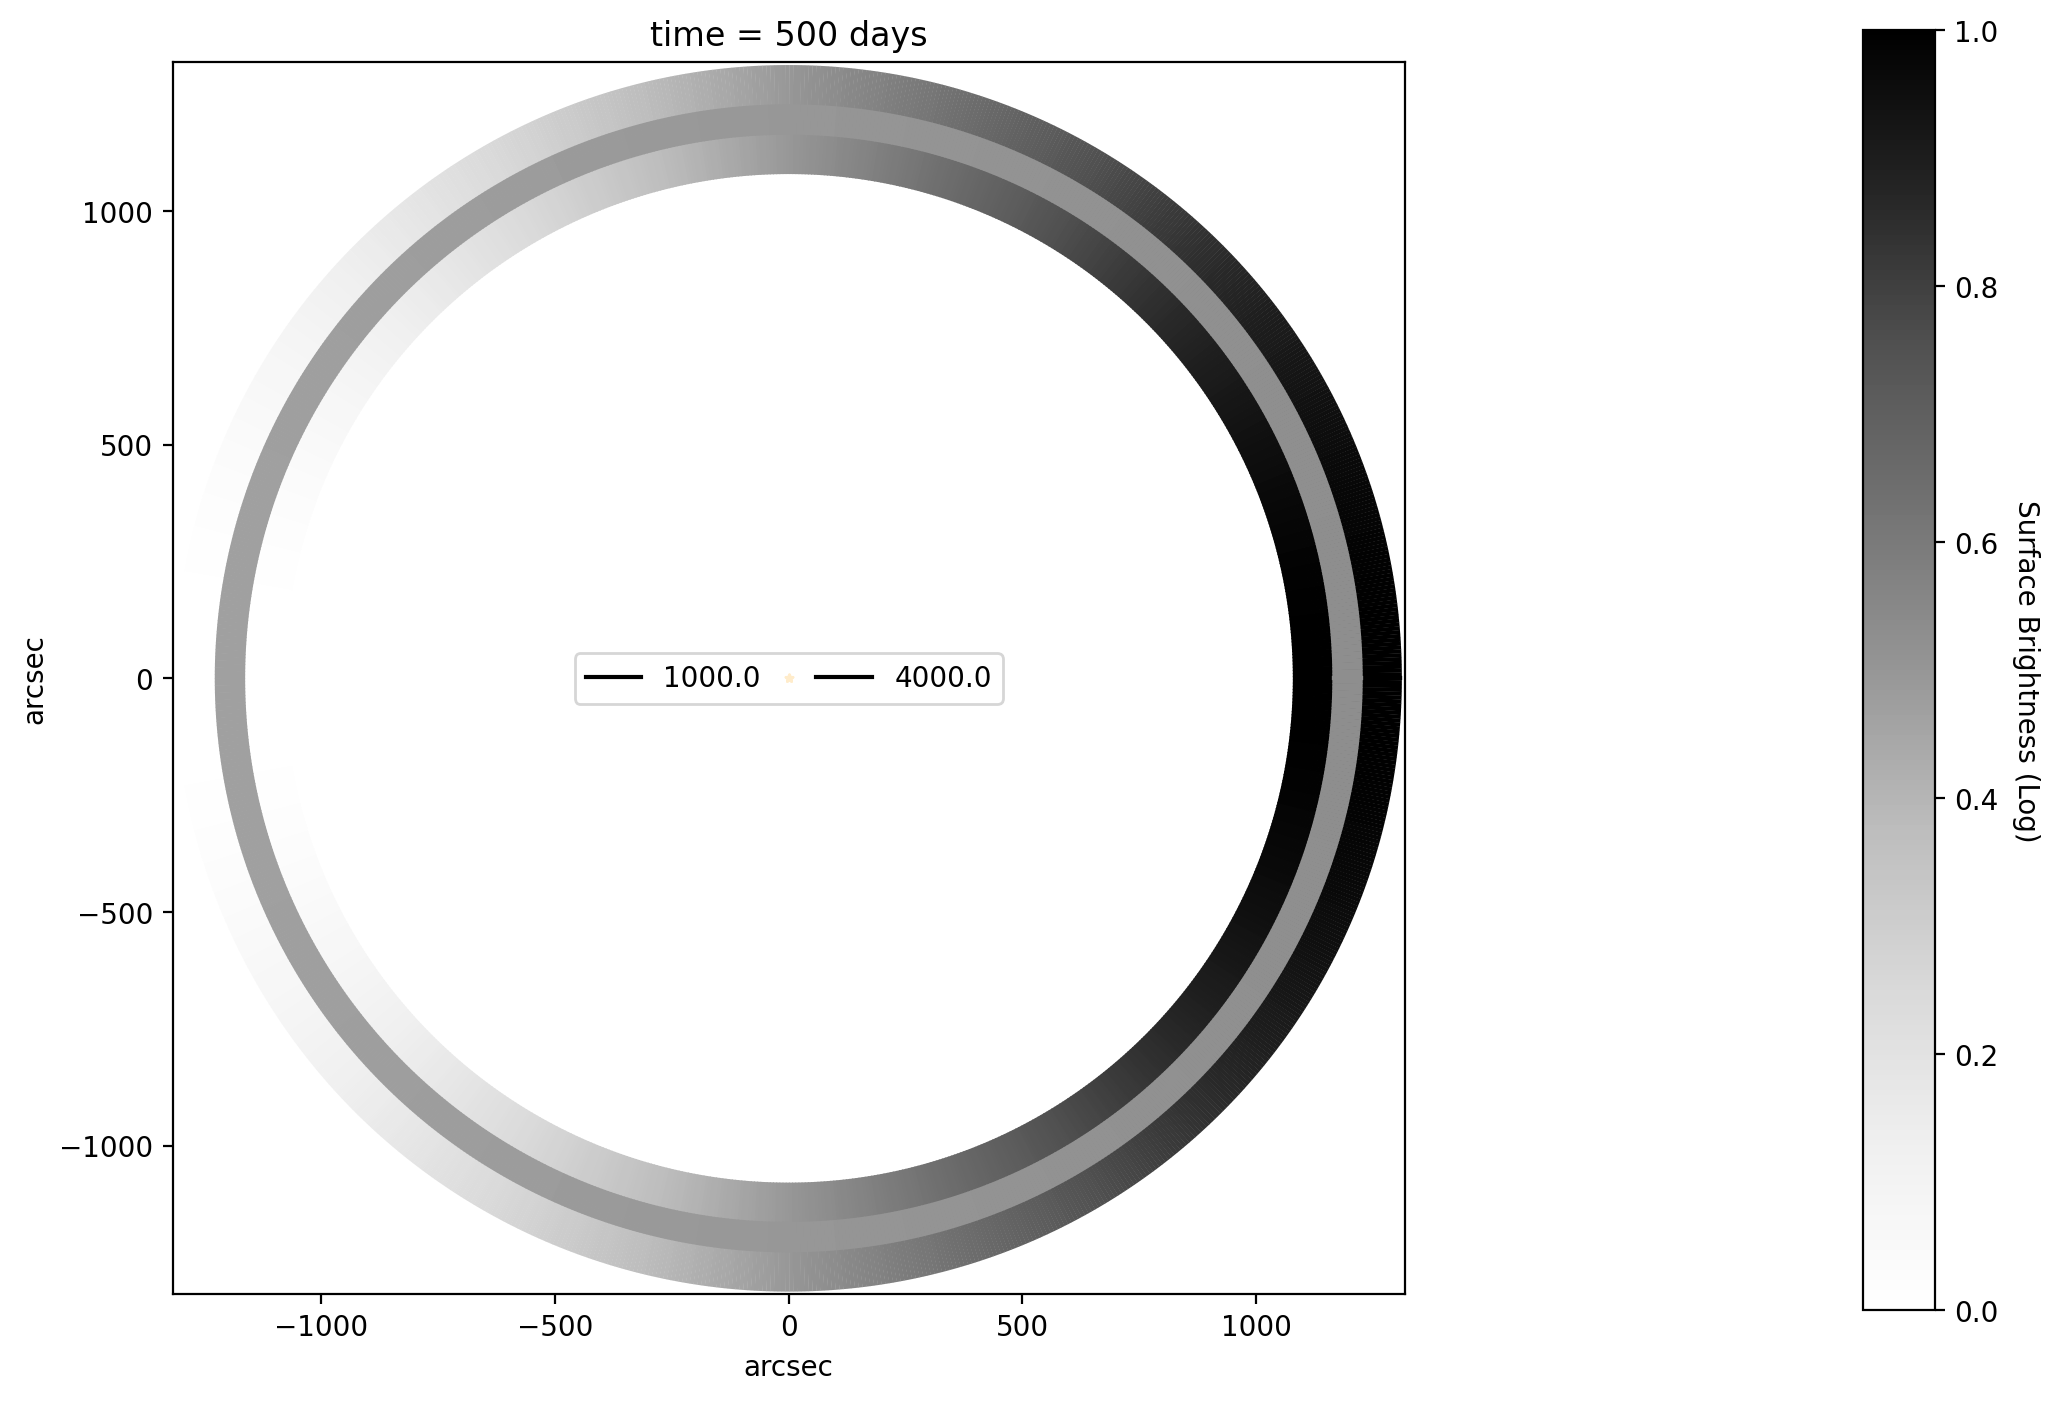

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))


ax.set_title("time = %s days"%int(t1 / dtoy))
cmap = matplotlib.colormaps.get_cmap('Greys')
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))
limit_max = np.max([max(np.ravel(xs)), max(np.ravel(ys))])
limit_min = np.min([min(np.ravel(xs)), min(np.ravel(ys))])

ax.set_xlim(limit_min - 10, limit_max + 10)
ax.set_ylim(limit_min - 10, limit_max + 10)


legend_dust = []
z0ly = [z0, d - z0]
alpha = [1, 1]
# Deltat = []

for i, z in enumerate(z0ly):
  if z < 0:
    # -- time ring star expanding
    ti = (-2 * z)/(c * (1 + a**2))
    # print(ti)
    if Deltat_y >= ti:
      print(Deltat_y / dtoy, ti / dtoy)
      print(z / pctoly)
      legend_dust.append(z / pctoly)
      for k in range(len(angle)):
        ax.plot(xs[i, :, k], ys[i, :, k], marker = "None", color=cmap(normalize(surface_300_norm[i, k])))#, label="%s"%(z/pctoly))
    else:
      ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
  else:
    for k in range(len(angle)):
      ax.plot(xs[i, :, k], ys[i, :, k], marker = "None", alpha = alpha[i], color=cmap(normalize(surface_300_norm[i, k])))#, label="%s"%(z/pctoly))
      legend_dust.append(z / pctoly)
    ax.scatter(-a * ct, 0, marker="*", s=7, color="orange")

ax.legend(set(legend_dust), loc='best',  ncol=4)

cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
# cb.update_ticks()
# # plt.tight_layout()
# # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
# # print(set(legend_dust))
plt.show()


In [136]:
def nh_xyz_dependece(x, lent = 10, n_h = n):
  """
    Define the density as a pairwise function that depends on the angle phi, the angle in the x,y sky plane

  """
  ll = len(x)

  nh = np.ones(lent) * n_h
  no = np.zeros((ll - lent))
  nhf = np.concatenate((nh, no))
  nhf = np.nan_to_num(nhf, nan = 0)
  return nhf

def nh_xyz_dependece_1(params, n_h = n):
  """
    Define the density as a pairwise function that depends on the angle phi, the angle in the x,y sky plane
    params[0]: x or angle to extract the len
    params[1]: size where the density is 0

  """
  ll = len(params[0])
  nhf = [n_h if i > params[1] else 0 for i in range(ll)]
  # nhf = [n_h if i % lent == 0 else 0 for i in range(ll)]
  return nhf

In [137]:
def surface_brightness_plane_xyz(Deltat_yn, z0lyn, dz0, angle, density_func, params):
  """
    Calculate the surface brightness per dust plane

    Arguments
        Deltat_y: time when the snap of the LE is taken by observer, in year
        z0ly: sitance of the dust in light-years
        dz0: thickness of the plane dust
        Nd: density

      Return:
        the surface brightness array per each dust plane
  """
  surface = np.zeros(len(angle))
  z = np.array(z0lyn)
  print(z, z.shape)
  Deltat_y = np.array(Deltat_yn)
  ct = Deltat_y * c
  # print(surface.shape)
  if z < 0:
    ti = (-2 * z)/(c * (1 + a**2))
    print(ti / dtoy, Deltat_y / dtoy)
    if ct/c >= ti:
      r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) )
      # print(r_le)
      x = r_le * np.cos(angle) - a * ct
      Nd = np.array([density_func(params)]).reshape(1, len(angle))
      # -- distance source - dust
      r = z - a * x + ct
      # -- rho = x^2 + y^2 = r_le
      rhodrho  = (dz0 * ct) + (z * c * dt0) + ct * dt0 * (1 + a**2)
      surface = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
    elif ct/c < ti:
      surface = Ir * np.zeros(len(angle))
  elif z >= 0:
    ti = 0
    if ct/c >= 0:
      r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2))
      x = r_le * np.cos(angle) - a * ct
      print(r_le)
      # print(r_le)
      Nd = np.array([density_func(params)]).reshape(1, len(angle))
      # -- distance source - dust
      r = z - a * x + ct
      # -- rho = x^2 + y^2 = r_le
      rhodrho  = (dz0 * ct) + (z * c * dt0) + ct * dt0 * (1 + a**2)
      surface = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)

  return surface


In [138]:
# angle = np.linspace(0, 2 * np.pi, 1000)

In [139]:
# s = surface_brightness_plane_xyz(np.array([280 * dtoy]), np.array([0.3 * pctoly]), dz0, angle, nh_xyz_dependece_1)

In [140]:
# s.shape

In [142]:
def final_plot_features_noloop(Deltat_yn, z0lyn, density_func, surface_func, phi_min = 0, phi_max = 2 * np.pi, size_phi = 500, params = []):
  """
    Calculate the final x,y coordiantes to plot and surface brightnes for color
    Arguments:
        Deltat_y: list of the time when the snap of the LE is taken by observer, in year
        z0ly: list og the disitance of the dust in light-years
        surface_func: function that define the surface brightness
        density_func: function that define the density of the dust
        phi_min = 0,
        phi_max = 2 * np.pi,
        size_phi = 500
        func: func(angle)
        p: power for the density funct e.g. density ~ func(angle) ** p or x ** p

      Return
        surface array, x and y coordiantes in arcseconds
  """

  z0ly = np.array(z0lyn)
  Deltat_y = np.array(Deltat_yn)
  ct = Deltat_y * c

  phi = np.linspace(phi_min, phi_max, size_phi)
  # print(phi.shape)

  surface = surface_func(Deltat_y, z0ly, dz0, phi, density_func, params)
  angle = phi.copy()


  if z0ly < 0:
    # -- time ring star expanding
    ti = (-2 * z0ly)/(c * (1 + a**2))
    # print(ti)
    if ct / c >= ti:
      xs, ys = xy_plane_ring_noloop(angle, z0ly, ct, dz0, dt0, a, d)
      new_xs, new_ys = xy_plot_dust_noloop(xs, ys, z0ly)
    else:
      new_xs = np.zeros((2, len(angle)))
      new_ys = np.zeros((2, len(angle)))
  else:
      xs, ys = xy_plane_ring_noloop(angle, z0ly, ct, dz0, dt0, a, d)
      new_xs, new_ys = xy_plot_dust_noloop(xs, ys, z0ly)



  return surface, new_xs, new_ys

In [161]:
def times_lt_dt0(Deltat_yn, z0lyn, angle, surface_func, density_func, params):
  # z0ly = np.array(z0) * pctoly
  # Deltat_y = np.array(Deltat) * dtoy
  z0ly = np.array(z0lyn)
  Deltat_y = np.array(Deltat_yn)
  # time = Deltat_y.copy()
  ct =  Deltat_y * c

  surface_300 = np.zeros((len(z0ly), len(angle)))
  new_xs_300 = np.zeros((len(z0ly), 2, len(angle)))
  new_ys_300 = np.zeros((len(z0ly), 2, len(angle)))

  for ii, qq in enumerate(z0ly):
      if qq < 0:
        surface_300[ii,:], new_xs_300[ii,:,:], new_ys_300[ii,:,:] = final_plot_features_noloop(Deltat_y, qq,  density_func,
                                                                                               surface_func, phi_min = 0, phi_max = 2 * np.pi , size_phi = len(angle),
                                                                                               params = params)
      else:
        ti = dt0
        # -- for time less than the duration of the flash light, all the dust within the paraboiloid define for the dust and the source would be illuminated.
        if ct / c <= ti:
          # -- rin and rout for the most inner ring keeps the same
          index = [k for k, x in enumerate(z0ly) if x >= 0]
          if ii == index[0]:
            print("inner here")
            print(ii, z0ly[ii] / pctoly)
            surface_300[ii,:], new_xs_300[ii,:,:], new_ys_300[ii,:,:] = final_plot_features_noloop(Deltat_y, qq, density_func,
                                                                                               surface_func, phi_min = 0, phi_max = 2 * np.pi , size_phi = len(angle),
                                                                                               params = params)
          else:
            print("rest here")
            # -- for the rest of the rings, rin is rout of the previous ring
            r_le_out = r_outin(qq, ct, dz0, dt0, a, d, "out")
            r_le_in = r_outin(z0ly[ii-1], ct, dz0, dt0, a, d, "out")
            print(qq / pctoly, z0ly[ii-1] / pctoly, r_le_out, r_le_in)
            radii = [r_le_out, r_le_in]
            xs = np.outer(radii, np.cos(angle)) - a * ct
            ys = np.outer(radii, np.sin(angle))
            # in order to have a closed area, the circles
            # should be traversed in opposite directions
            xs[1,:] = xs[1,::-1]
            ys[1,:] = ys[1,::-1]
            surface_300[ii,:] = surface_func(Deltat_y, qq, dz0, angle, density_func, params)
            new_xs_300[ii,:,:], new_ys_300[ii,:,:] = xy_plot_dust_noloop(xs, ys, qq)

  return surface_300, new_xs_300, new_ys_300


In [168]:
def plot_LE_plane(Deltat_yn, z0lyn, angle, surface_func, density_func, params):

  """
    Plot the Light Echo for a (one) given time and multiple dust plane locations

    Arguments:
      Deltat_y: list of time of "screenshot" in years
      z0ly: list of positions of the dust plane in pc from the source in light years
      angle: angle in the sky plane
      surface_func: function that define the surface brightness
      density_func: function that define the density of the dust
      func: func(angle)
      p: power for the density funct e.g. density ~ func(angle) ** p or x ** p

    Return:
      Plot

  """

  z0ly = np.array(z0lyn)
  print(z0ly)
  Deltat_y = np.array(Deltat_yn)
  ct =  Deltat_y * c

  surface_300 = np.zeros((len(z0ly), len(angle)))
  new_xs_300 = np.zeros((len(z0ly), 2, len(angle)))
  new_ys_300 = np.zeros((len(z0ly), 2, len(angle)))


  if ct / c >= dt0:
    for ii, qq in enumerate(z0ly):
      surface_300[ii,:], new_xs_300[ii,:,:], new_ys_300[ii,:,:] = final_plot_features_noloop(Deltat_y, qq,  density_func,
                                                                                    surface_func, phi_min = 0, phi_max = 2 * np.pi , size_phi = len(angle),
                                                                                    params = params)

  else:
    print("plot LE here")
    surface_300, new_xs_300, new_ys_300 = times_lt_dt0(Deltat_y, z0ly, angle, surface_func, density_func, params)


  surface_300_norm = ( surface_300.copy() - np.nanmin(surface_300.copy())  ) / (np.nanmax(surface_300.copy()) - np.nanmin(surface_300.copy()))

  xs = new_xs_300.copy()
  ys = new_ys_300.copy()


  fig, ax = plt.subplots(1, 1, figsize=(12, 8))


  ax.set_title("time = %s days"%int(Deltat_y / dtoy))
  cmap = matplotlib.colormaps.get_cmap('Greys')
  normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))
  limit_max = np.max([max(np.ravel(xs)), max(np.ravel(ys))])
  limit_min = np.min([min(np.ravel(xs)), min(np.ravel(ys))])

  ax.set_xlim(limit_min - 10, limit_max + 10)
  ax.set_ylim(limit_min - 10, limit_max + 10)


  legend_dust = []

  for i, z in enumerate(z0ly):
    if z < 0:
      # -- time ring star expanding
      ti = (-2 * z)/(c * (1 + a**2))
      # print(ti)
      if ct / c >= ti:
        print(Deltat_y / dtoy, ti / dtoy)
        print(z / pctoly)
        legend_dust.append(z / pctoly)
        for k in range(len(angle)):
          ax.plot(xs[i, :, k], ys[i, :, k], marker = "None", color=cmap(normalize(surface_300_norm[i, k])))#, label="%s"%(z/pctoly))
      else:
        ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
    else:
      for k in range(len(angle)):
        ax.plot(xs[i, :, k], ys[i, :, k], marker = "None", color=cmap(normalize(surface_300_norm[i, k])))#, label="%s"%(z/pctoly))
        legend_dust.append(z / pctoly)
      ax.scatter(-a * ct, 0, marker="*", s=7, color="orange")

  ax.legend(set(legend_dust), loc='best',  ncol=4)

  cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

  ax.set_xlabel("arcsec")
  ax.set_ylabel("arcsec")
  ax.set_box_aspect(1)

  cb = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
  cb.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

  def label_cbrt(x,pos):
      return "{:.1f}".format(x)

  cb.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
  # cb.update_ticks()
  # # plt.tight_layout()
  # # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
  # # print(set(legend_dust))
  plt.show()


  return ax, surface_300, xs, ys

[0.]
0.0 ()
[0.23324478]
[0.2191784] 0.1369865


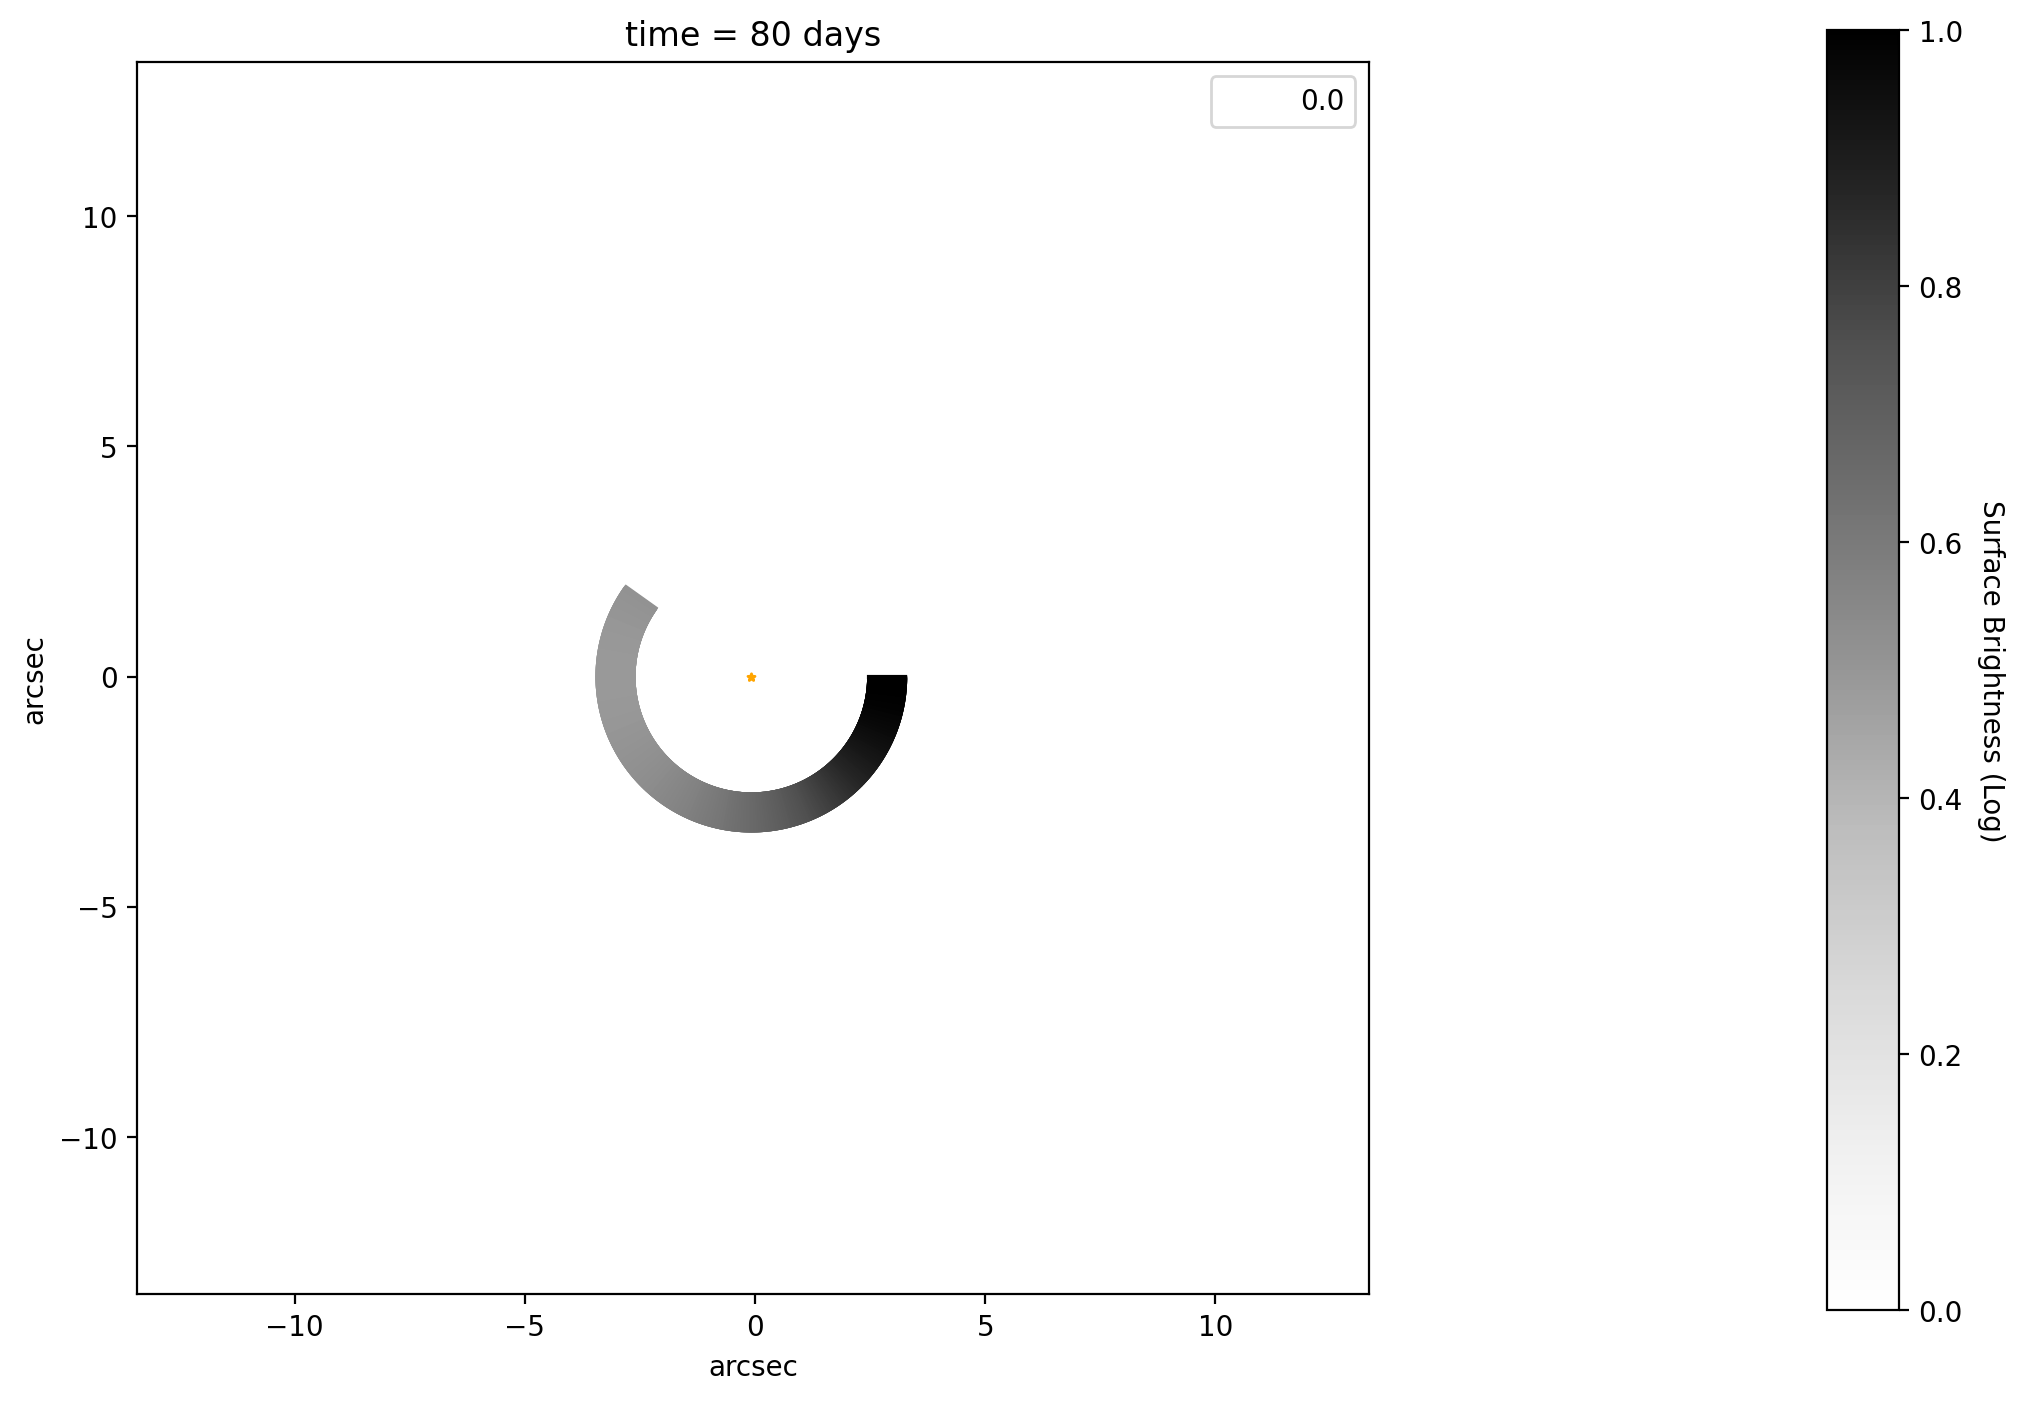

In [145]:
ax2, surface, new_xs, new_ys = plot_LE_plane(np.array([80 * dtoy]), np.array([0 * pctoly]), angle,
                                             surface_func = surface_brightness_plane_xyz, density_func = nh_xyz_dependece_1, params = [angle, 400])

[-0.326156  0.        0.978468  3.26156 ]
-0.326156 ()
210.24188200658946 [280.]
[0.7671244] 0.1369865
0.0 ()
[0.81635674]
[0.7671244] 0.1369865
0.9784679999999999 ()
[1.4722947]
[0.7671244] 0.1369865
3.26156 ()
[2.38127756]
[0.7671244] 0.1369865
[280.] 210.24188200658946
-0.1


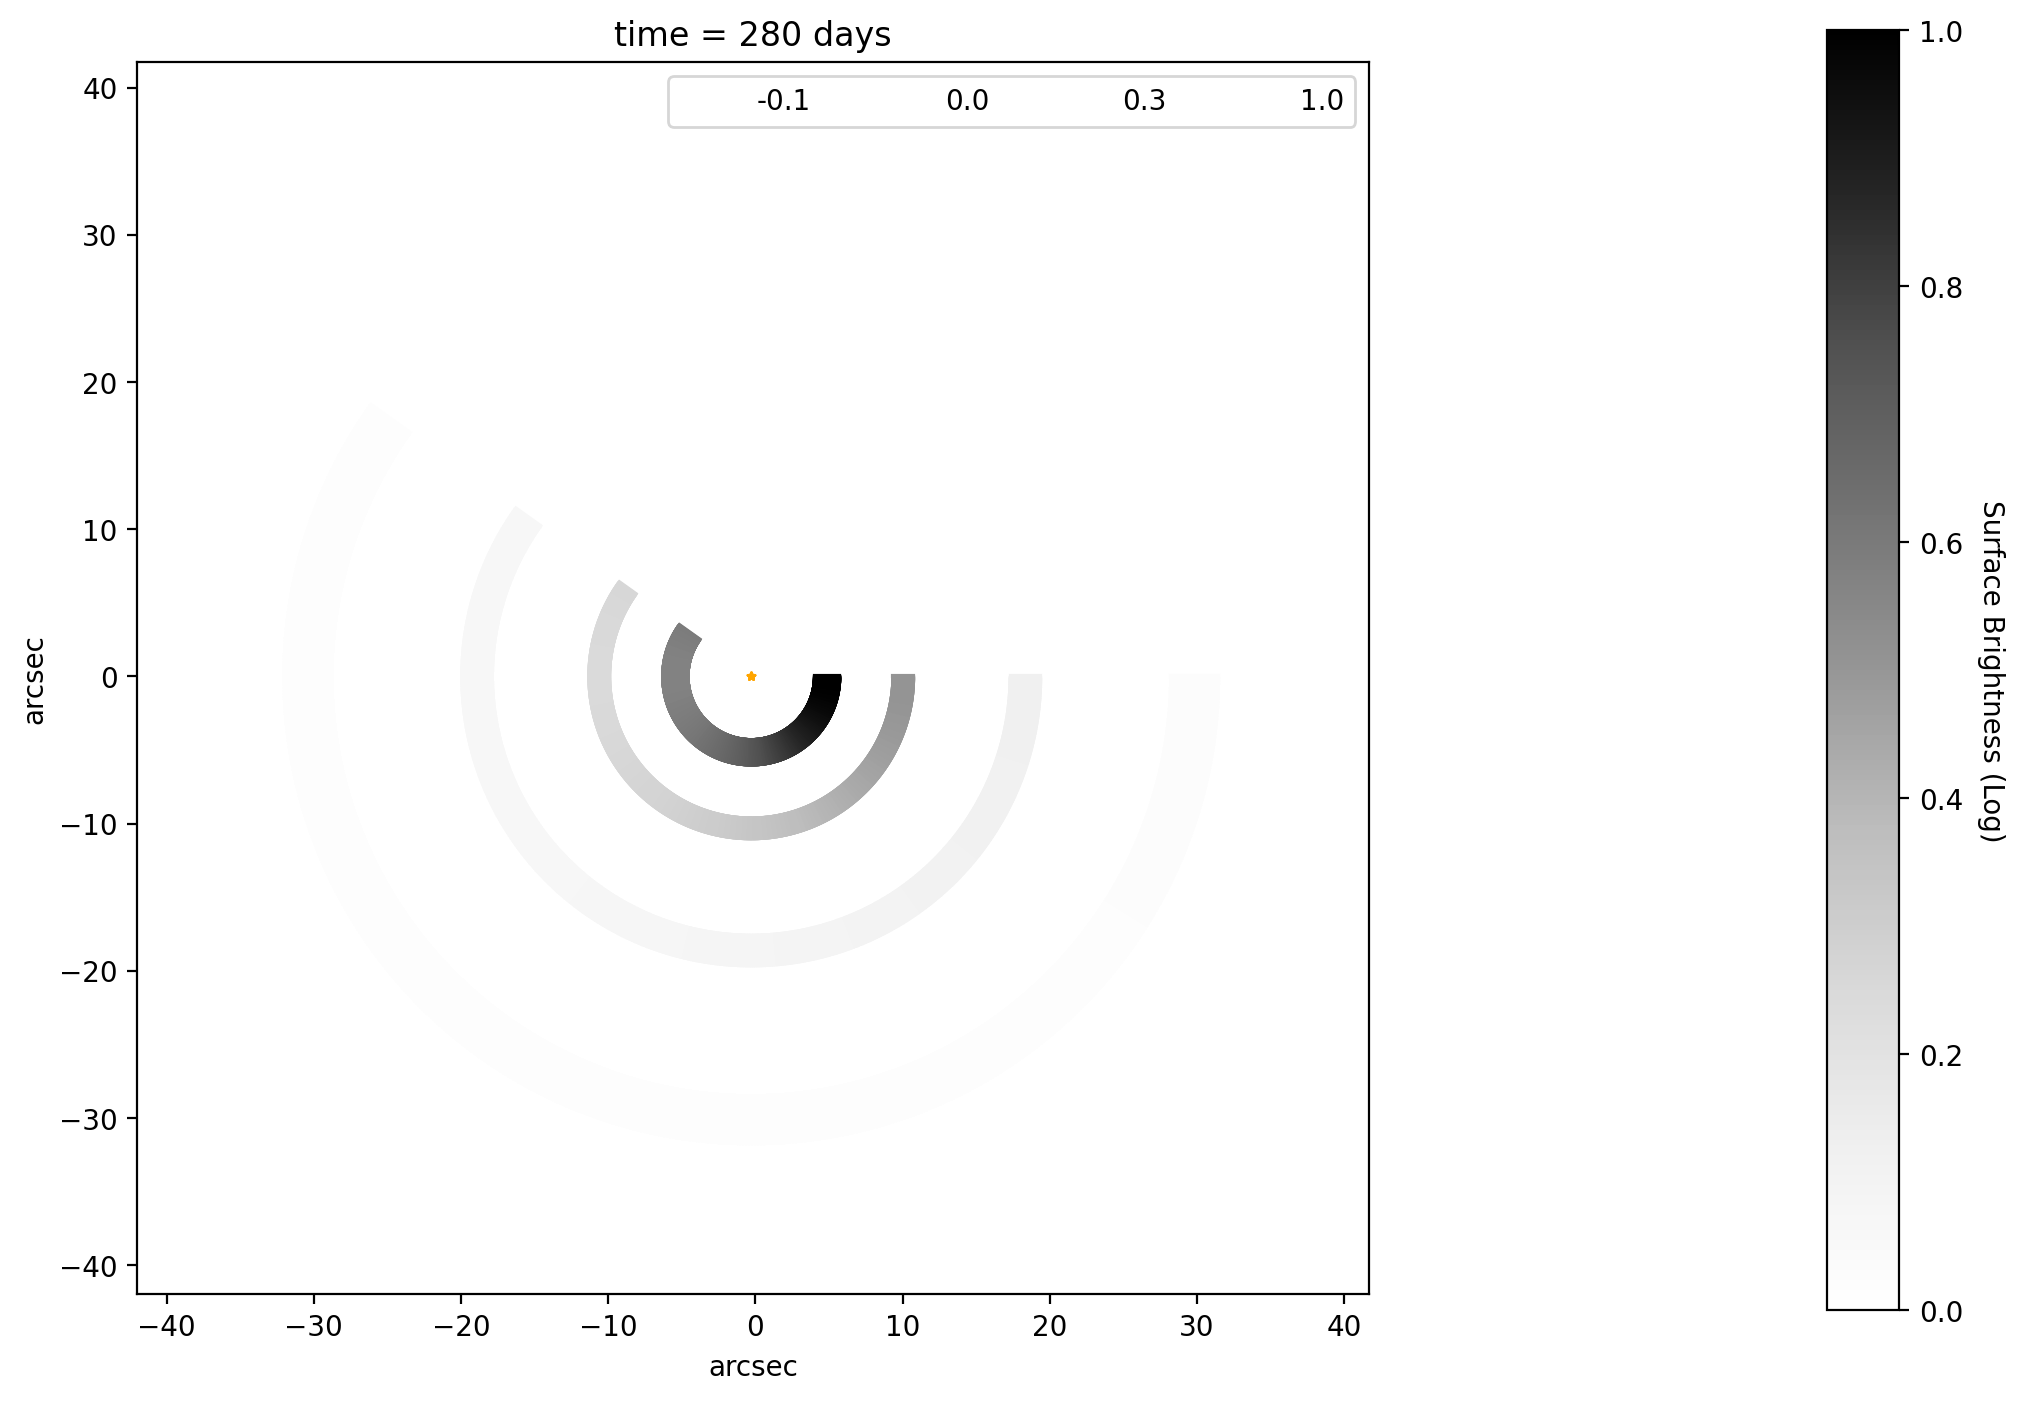

In [146]:
size_phi = 1000
angle = np.linspace(0, 2 * np.pi, size_phi)
z0 = [-0.10, 0, 0.3, 1] # pc
pctoly = 3.26156 # 1pc = 3.26156 light-year
z0ly = np.array(z0) * pctoly
ax2, surface, new_xs, new_ys = plot_LE_plane(np.array([280 * dtoy]), z0ly, angle,
                                             surface_func = surface_brightness_plane_xyz, density_func = nh_xyz_dependece_1, params = [angle, 400])

In [152]:
size_phi = 1000
angle = np.linspace(0, 2 * np.pi, size_phi)
z0 = [-0.10, 0, 0.3, 1] # pc
z0ly = np.array(z0) * pctoly
NN = np.random.uniform(0, n, size_phi)

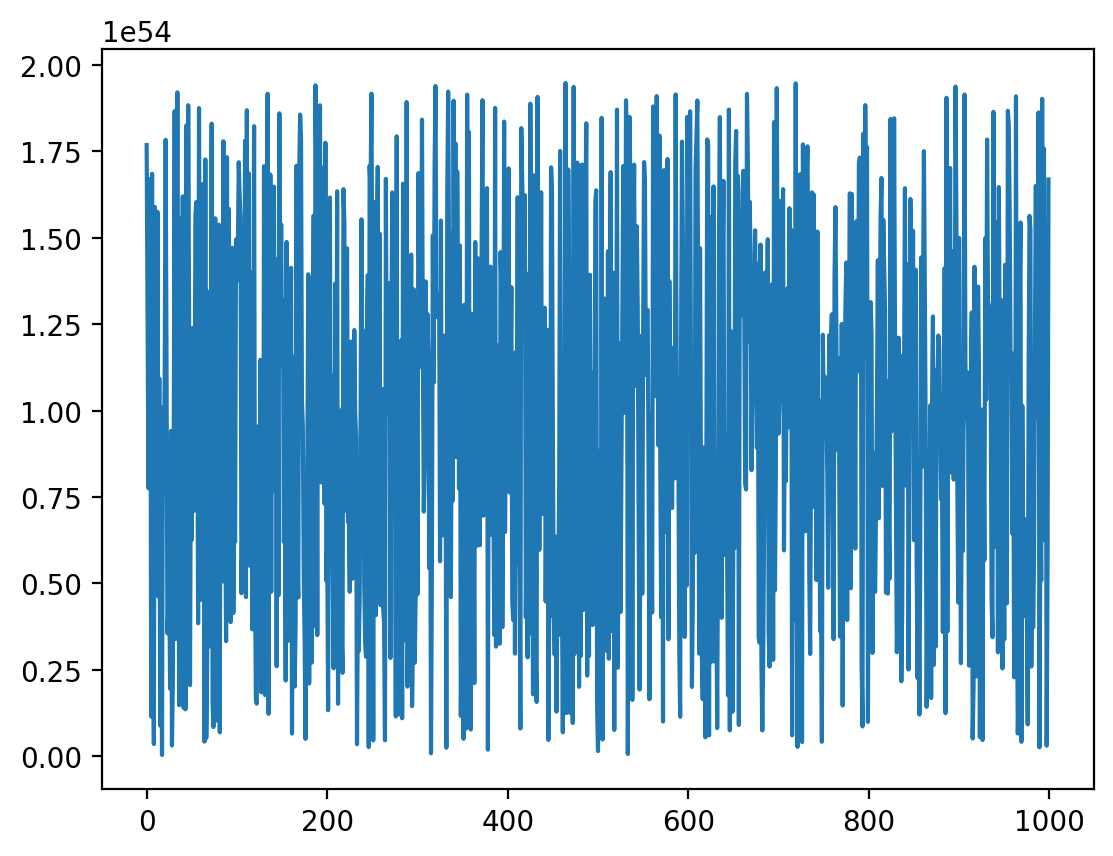

In [153]:
plt.plot(NN)

In [155]:
def nh_array(params, n_h = n):
  """
    Define the density as a pairwise function that depends on the angle phi, the angle in the x,y sky plane
    params[0]: x or angle to extract the len
    params[1]: size where the density is 0

  """
  ll = len(params[0])
  nhf = np.random.uniform(0, n_h, ll)
  # nhf = [n_h if i % lent == 0 else 0 for i in range(ll)]
  return nhf

In [167]:
a * 280 * dtoy

0.27921044757931995

[-0.326156  0.        0.978468  3.26156 ]
-0.326156 ()
210.24188200658946 [280.]
[0.7671244] 0.1369865
0.0 ()
[0.81635674]
[0.7671244] 0.1369865
0.9784679999999999 ()
[1.4722947]
[0.7671244] 0.1369865
3.26156 ()
[2.38127756]
[0.7671244] 0.1369865
[280.] 210.24188200658946
-0.1


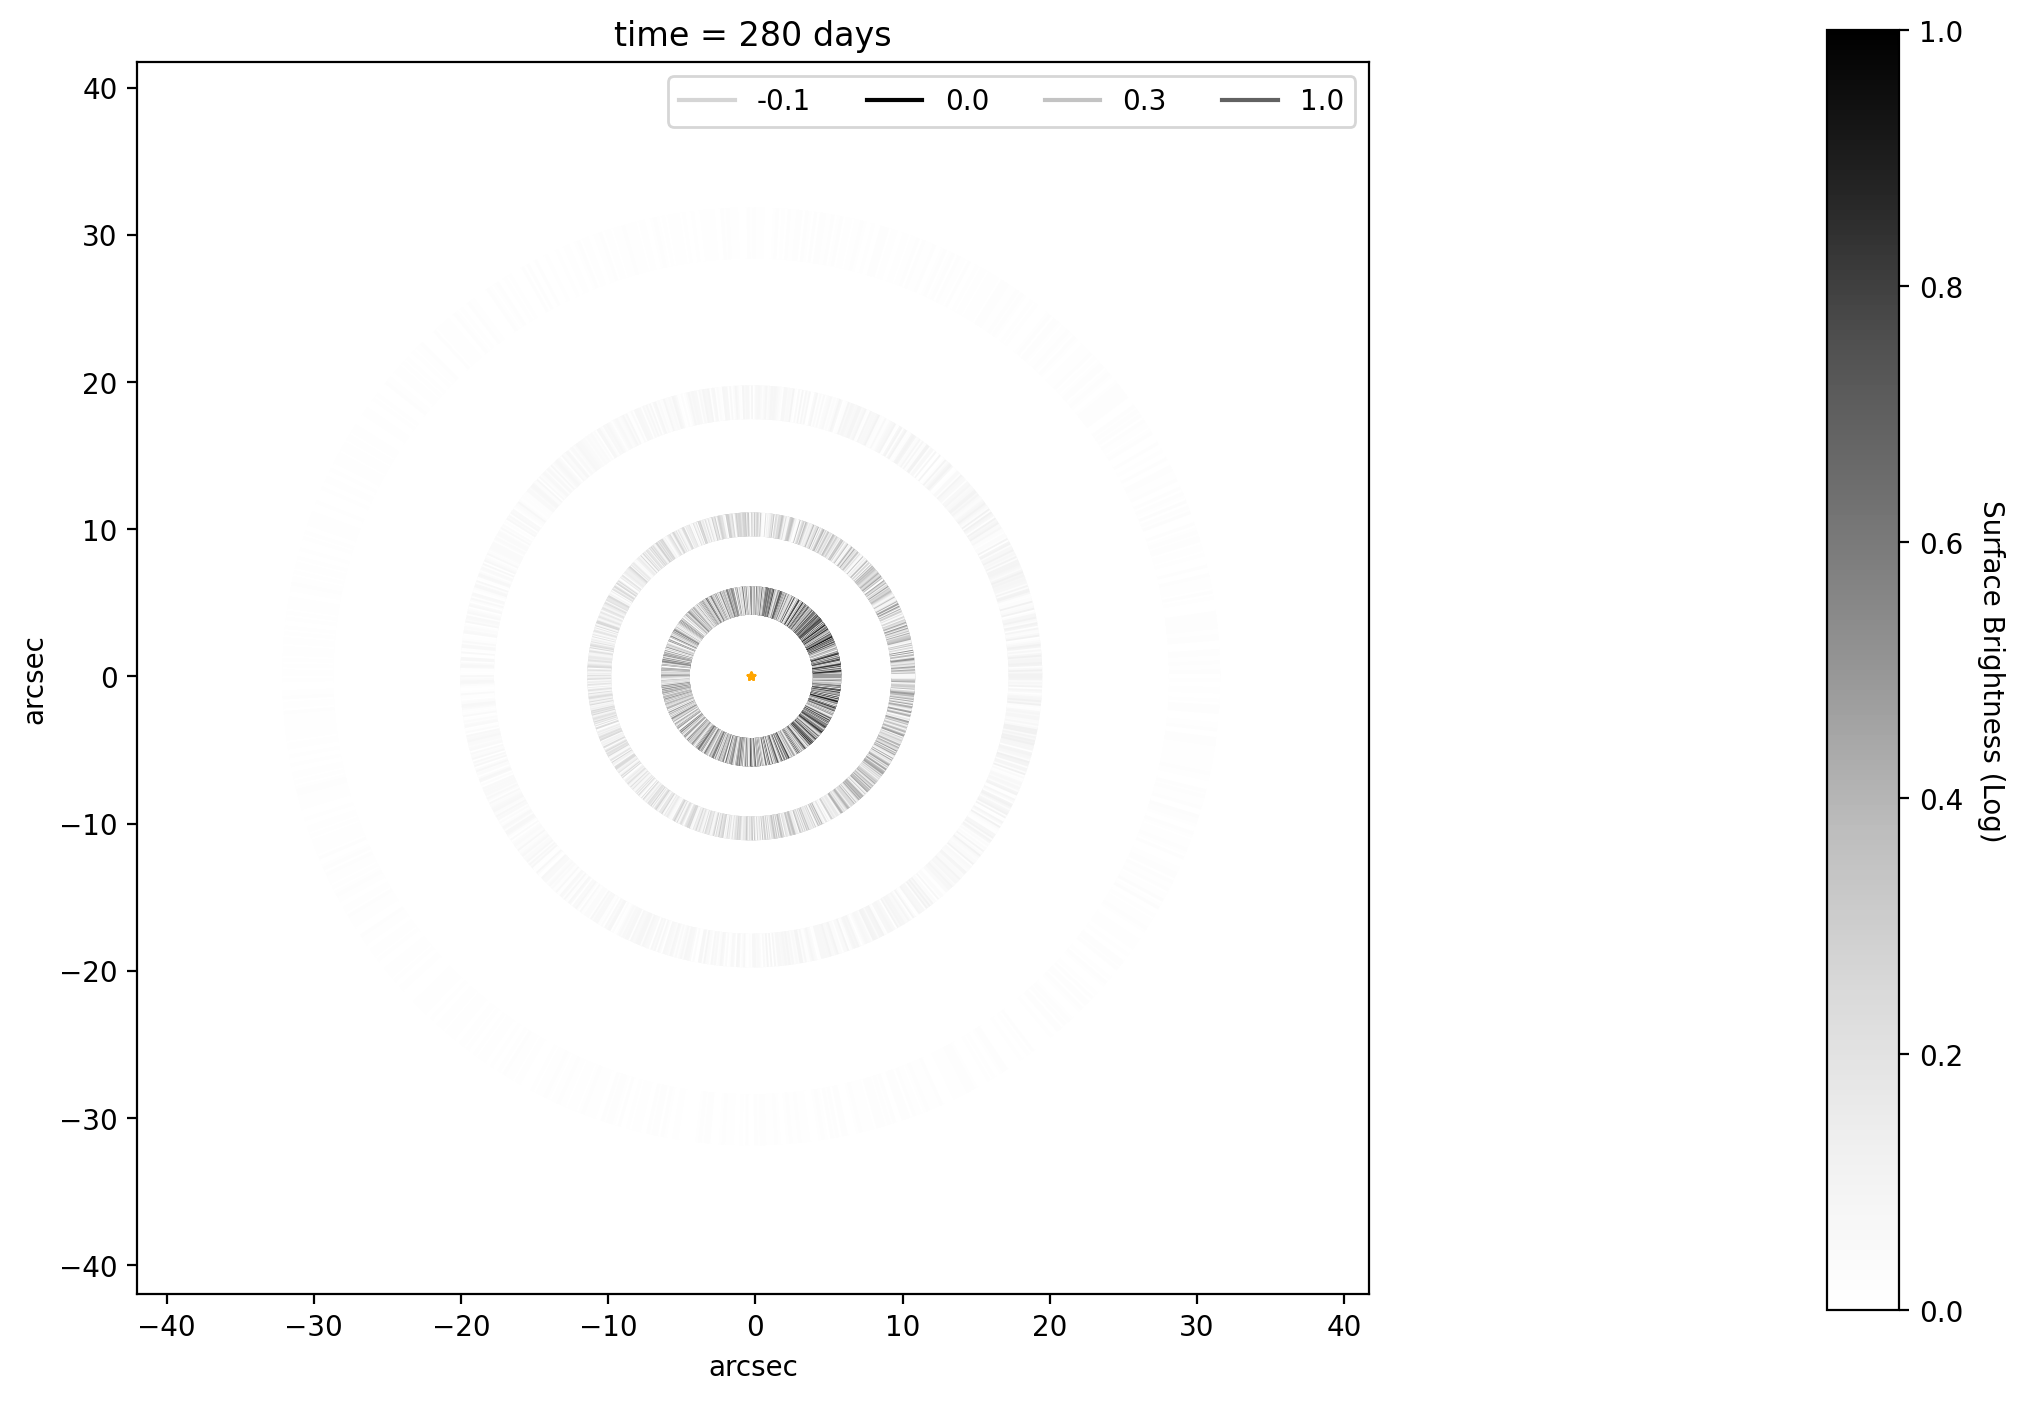

In [169]:
size_phi = 1000
angle = np.linspace(0, 2 * np.pi, size_phi)
z0 = [-0.10, 0, 0.3, 1] # pc
pctoly = 3.26156 # 1pc = 3.26156 light-year
z0ly = np.array(z0) * pctoly
ax2, surface, new_xs, new_ys = plot_LE_plane(np.array([280 * dtoy]), z0ly, angle,
                                             surface_func = surface_brightness_plane_xyz, density_func = nh_array, params = [angle])

In [172]:
np.repeat(np.arange(10), 2)

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9])

In [175]:
arr_test = np.random.uniform(0,1,5)

In [179]:
result_array = np.repeat(arr_test, 2)

In [180]:
result_array

array([0.35679852, 0.35679852, 0.27179752, 0.27179752, 0.11073661,
       0.11073661, 0.33954521, 0.33954521, 0.64146147, 0.64146147])

In [183]:
def nh_array_1(params, n_h = n):
  """
    Define the density as a pairwise function that depends on the angle phi, the angle in the x,y sky plane
    params[0]: x or angle to extract the len
    params[1]: size where the density is 0

  """
  ll = len(params[0])
  nh = np.random.uniform(0, n_h, int(ll/200))
  nhf = np.repeat(nh, 200)
  # nhf = [n_h if i % lent == 0 else 0 for i in range(ll)]
  return nhf

[-0.326156  0.        0.978468  3.26156 ]
-0.326156 ()
210.24188200658946 [280.]
[0.7671244] 0.1369865
0.0 ()
[0.81635674]
[0.7671244] 0.1369865
0.9784679999999999 ()
[1.4722947]
[0.7671244] 0.1369865
3.26156 ()
[2.38127756]
[0.7671244] 0.1369865
[280.] 210.24188200658946
-0.1


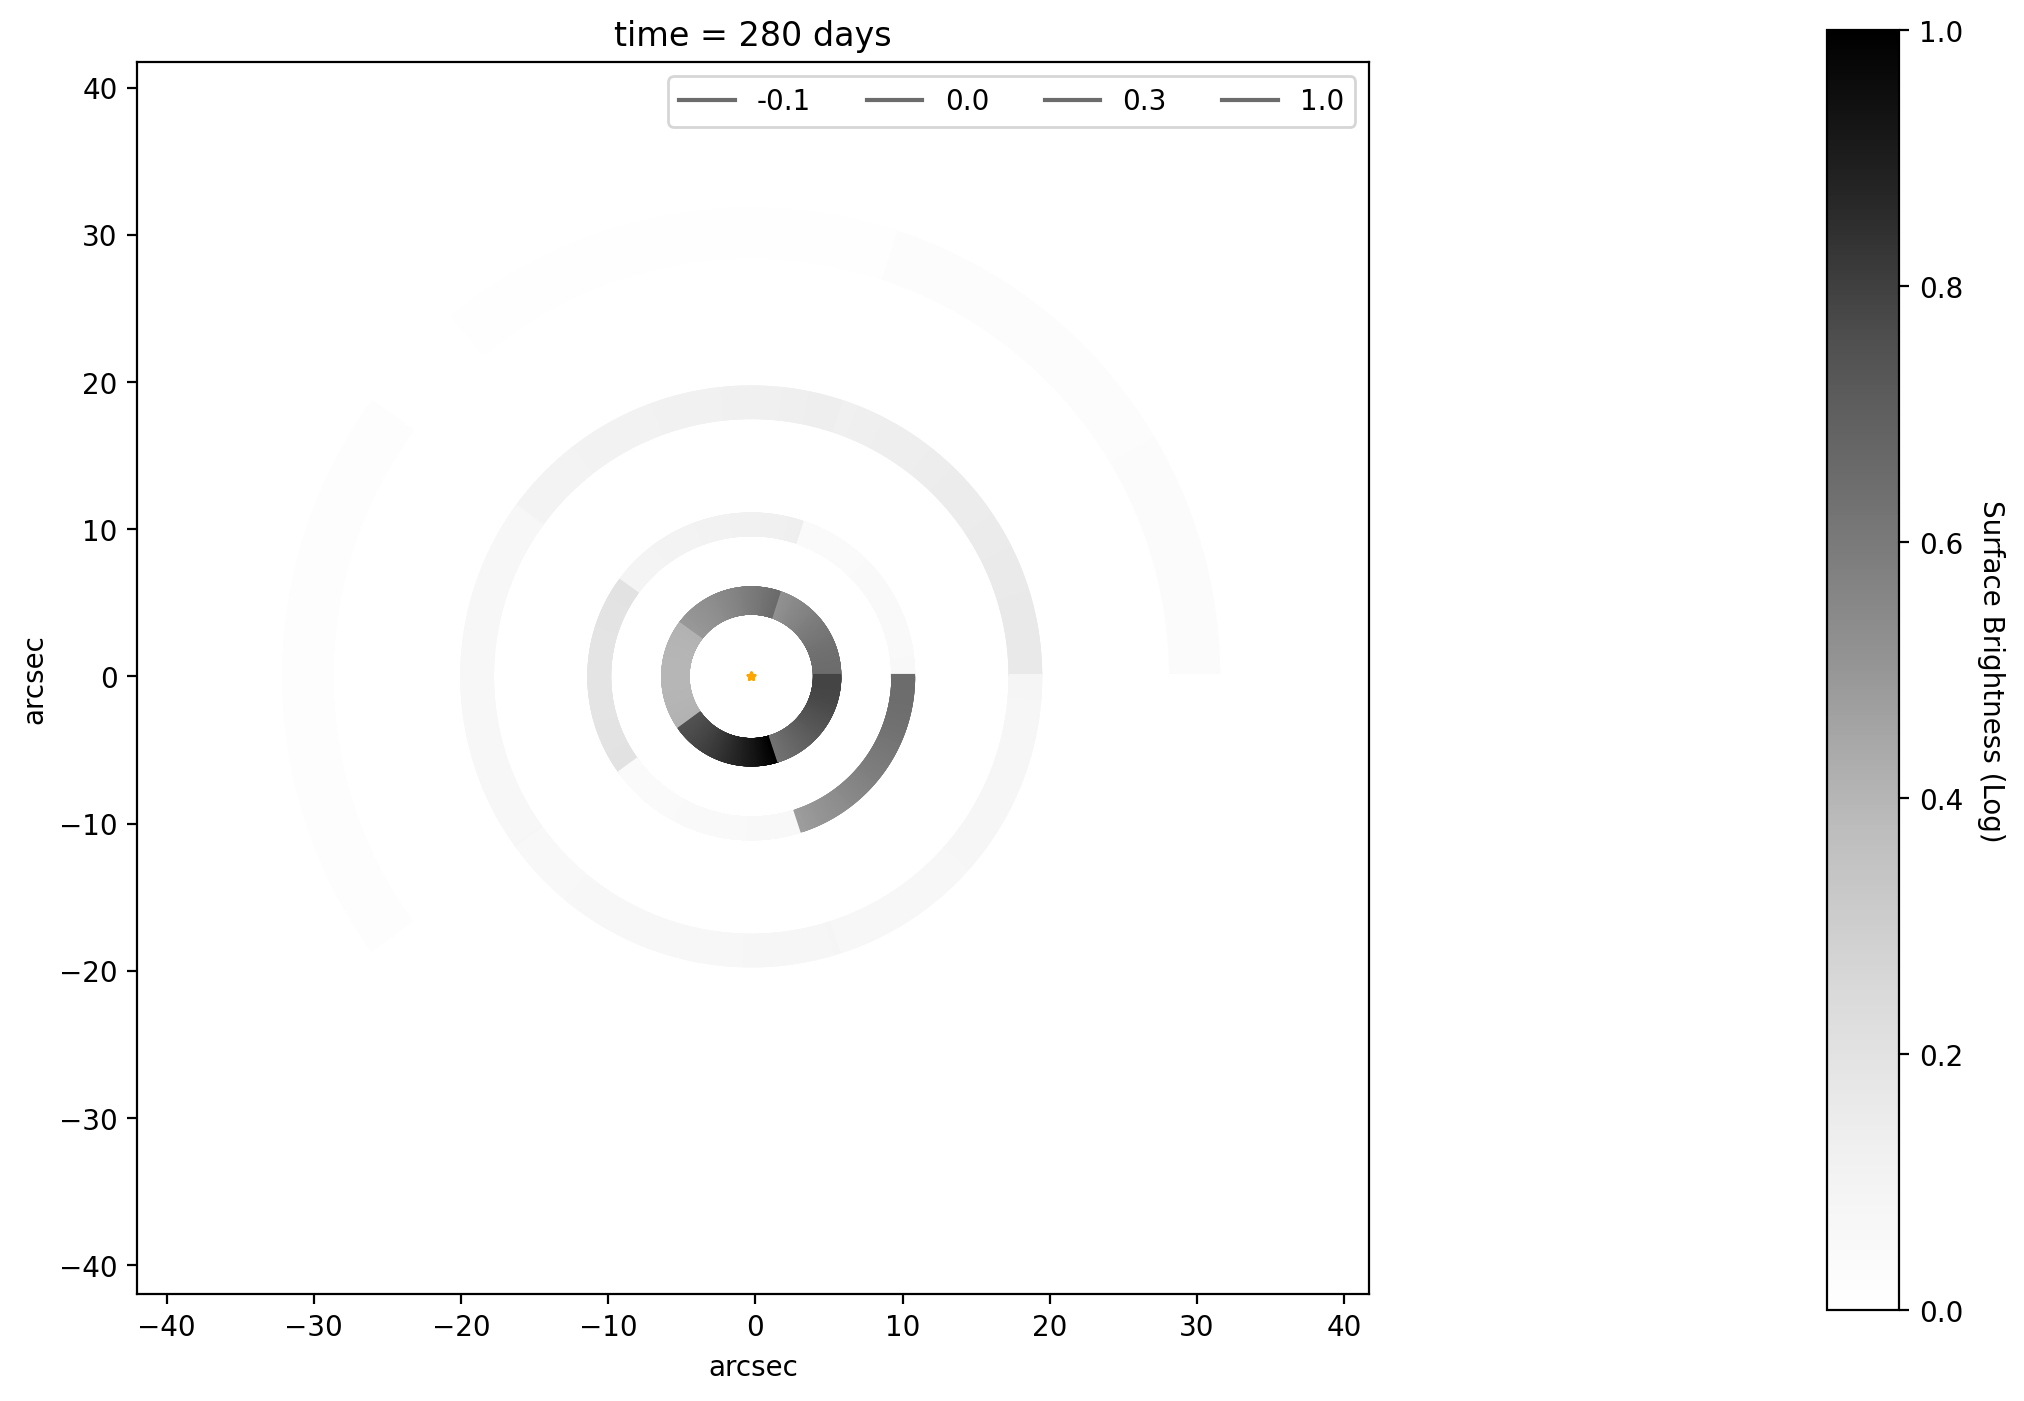

In [184]:
size_phi = 1000
angle = np.linspace(0, 2 * np.pi, size_phi)
z0 = [-0.10, 0, 0.3, 1] # pc
pctoly = 3.26156 # 1pc = 3.26156 light-year
z0ly = np.array(z0) * pctoly
ax2, surface, new_xs, new_ys = plot_LE_plane(np.array([280 * dtoy]), z0ly, angle,
                                             surface_func = surface_brightness_plane_xyz, density_func = nh_array_1, params = [angle])

In [53]:
t1

1.369865

In [54]:
np.sqrt(2 * (0.3 * pctoly) * c*t1 + (c*t1)**2 * (1 + a**2) )

2.148397503447366

In [55]:
t2y = 6.407420187315438e-05

In [56]:
np.sqrt(2 * ((5000-0.3) * pctoly) * c*t2y + (c*t2y)**2 * (1 + a**2) )

1.445577100584706

In [57]:
# !pip install ipympl

In [58]:
(1 / 19900 ) / dtoy

0.018341681947274743

In [59]:
radii = [2,0]
xs = np.outer(radii, np.cos(angle))
ys = np.outer(radii, np.sin(angle))

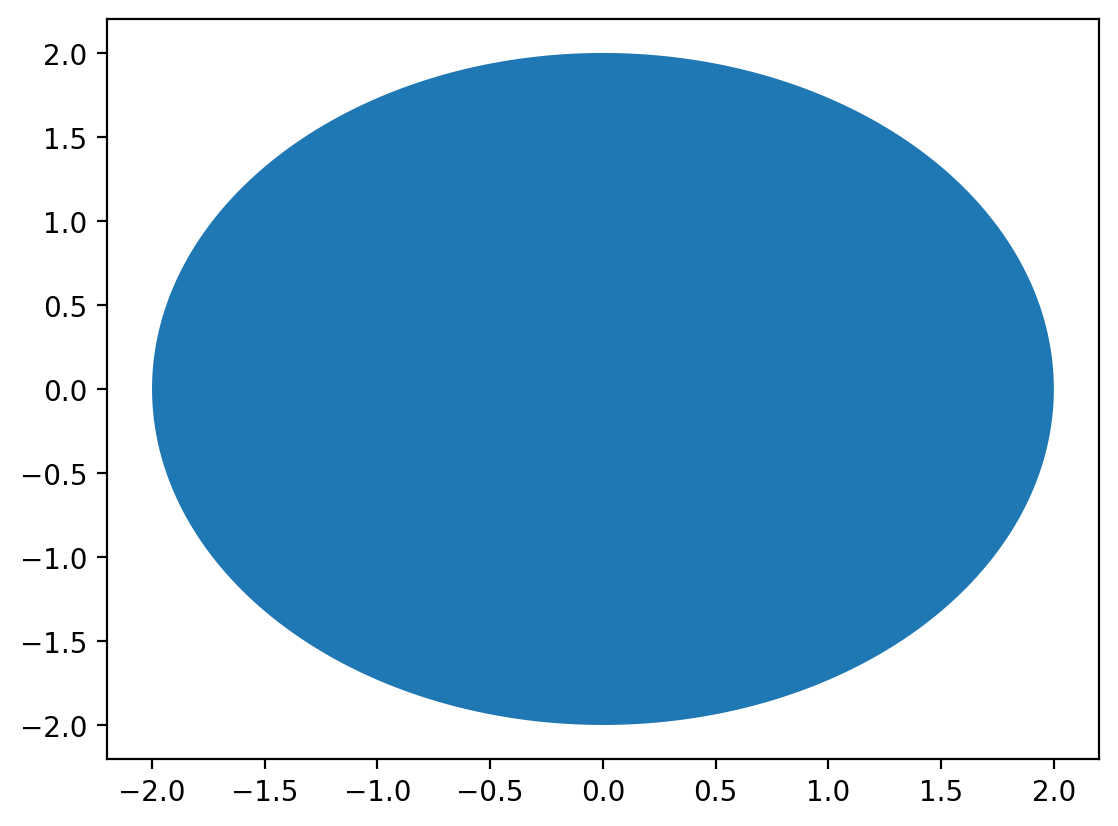

In [60]:
plt.fill(np.ravel(xs), np.ravel(ys))

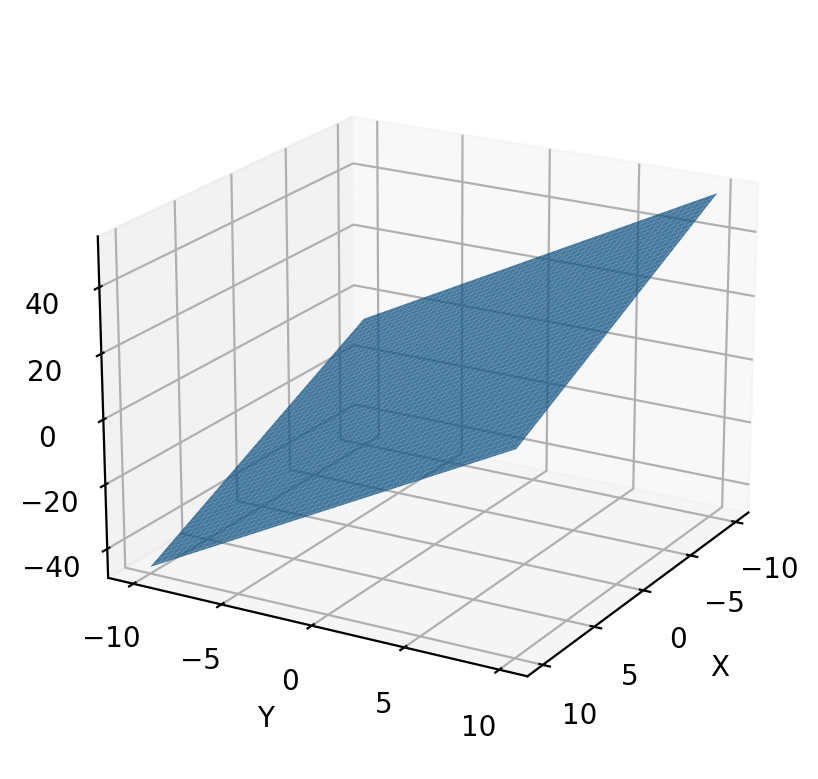

In [61]:
# TO SHOW INTERACTIVE PLOT
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager()
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# Define the plane equation
def plane_equation(x, y):
    return -2 * x + 3 * y + 3

# Create a meshgrid of x and y values
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = plane_equation(X, Y)

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the plane surface
ax.plot_surface(X, Y, Z, alpha=0.8)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the view angle
ax.view_init(elev=20, azim=30)

# Show the plot
plt.show()


In [62]:

beta = 30 * np.pi / 180
alpha = 10 * np.pi / 180
z0ly = 0.3 * pctoly
z0ly

0.9784679999999999

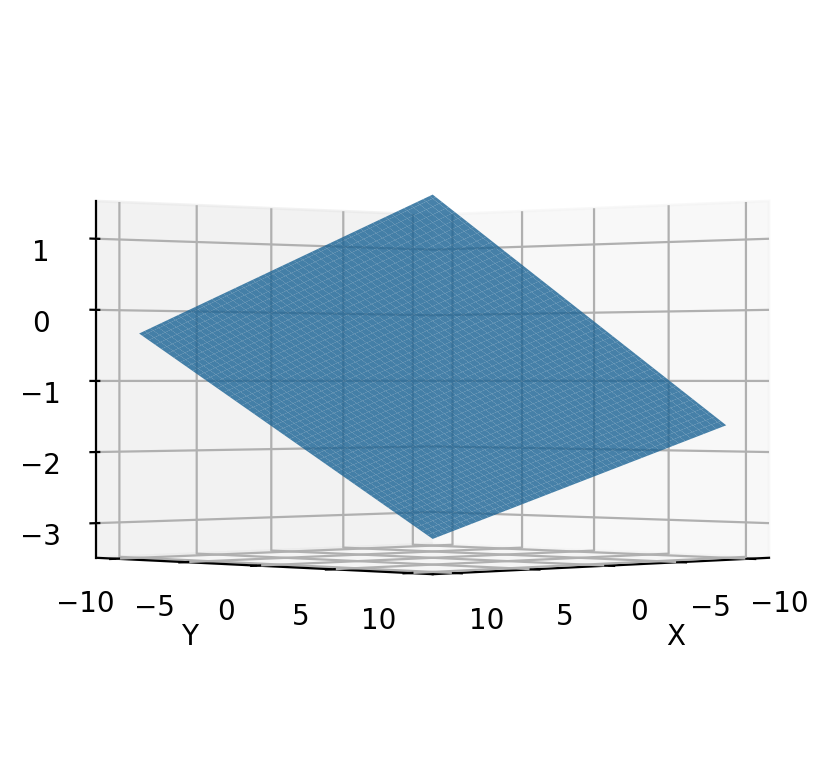

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

beta = 30 * np.pi / 180
alpha = 10 * np.pi / 180
z0ly = 0.3 * pctoly
# Define the plane equation
def plane_equation(x, y):
    return -z0ly + np.tan(alpha) * (x * np.cos(beta) + y * np.sin(beta))

# Create a meshgrid of x and y values
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = plane_equation(X, Y)

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the plane surface
ax.plot_surface(X, Y, Z, alpha=0.8)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the view angle
ax.view_init(elev=0, azim=45)

# Show the plot
plt.show()
